## Learning average SR

In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/network/home/penmetss/DeepRL/deeprl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/network/home/penmetss/DeepRL/deeprl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/network/home/penmetss/DeepRL/deeprl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/network/home/penmetss/DeepRL/deeprl/lib

In [2]:
from deep_rl.component.fourrooms import FourRooms
env = FourRooms(goal=94)

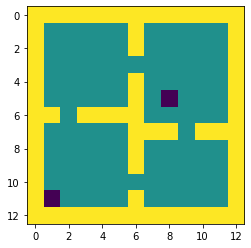

In [3]:
env.reset()
plt.imshow(env.render())

In [4]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                         Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    
# DQN
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e5
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [5]:
mkdir('log')
mkdir('tf_log')
set_one_thread()
random_seed()
select_device(-1)

In [6]:
game = 'FourRooms'
agent1 = dsr_feature(game='FourRooms-Goal-9')

2020-03-08 17:08:58,949 - root - INFO: steps 0, 127100121.21 steps/s
2020-03-08 17:08:59,507 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-03-08 17:08:59,707 - root - INFO: steps 23, episodic_return_train -23
2020-03-08 17:08:59,781 - root - INFO: steps 223, episodic_return_train -200
2020-03-08 17:08:59,854 - root - INFO: steps 423, episodic_return_train -200
2020-03-08 17:08:59,871 - root - INFO: steps 466, episodic_return_train -42
2020-03-08 17:08:59,945 - root - INFO: steps 666, episodic_return_train -200
2020-03-08 17:09:00,019 - root - INFO: steps 866, episodic_return_train -200
2020-03-08 17:09:00,030 - root - INFO: steps 895, episodic_return_train -28
2020-03-08 17:09:00,069 - root - INFO: steps 1000, 894.77 steps/s
2020-03-08 17:09:00,098 - root - INFO: steps 1015, episodic_return_train -119
2020-03-08 17:09:00,347 - root - INFO: steps 1215, episodic_return_train -200
2020-03-08 17:09:00,450 - root - INFO: steps 1296, episodic_return_train -80
2020-03-08 17:

2020-03-08 17:09:17,444 - root - INFO: steps 14716, episodic_return_train -11
2020-03-08 17:09:17,676 - root - INFO: steps 14916, episodic_return_train -200
2020-03-08 17:09:17,691 - root - INFO: steps 14928, episodic_return_train -11
2020-03-08 17:09:17,774 - root - INFO: steps 15000, 856.39 steps/s
2020-03-08 17:09:18,230 - root - INFO: steps 15000, episodic_return_test -162.50(23.73)
2020-03-08 17:09:18,379 - root - INFO: steps 15128, episodic_return_train -200
2020-03-08 17:09:18,482 - root - INFO: steps 15218, episodic_return_train -89
2020-03-08 17:09:18,492 - root - INFO: steps 15224, episodic_return_train -5
2020-03-08 17:09:18,498 - root - INFO: steps 15229, episodic_return_train -4
2020-03-08 17:09:18,499 - root - INFO: steps 15231, episodic_return_train -1
2020-03-08 17:09:18,558 - root - INFO: steps 15275, episodic_return_train -43
2020-03-08 17:09:18,578 - root - INFO: steps 15290, episodic_return_train -14
2020-03-08 17:09:18,585 - root - INFO: steps 15293, episodic_retur

2020-03-08 17:09:28,509 - root - INFO: steps 23413, episodic_return_train -44
2020-03-08 17:09:28,746 - root - INFO: steps 23613, episodic_return_train -200
2020-03-08 17:09:28,772 - root - INFO: steps 23632, episodic_return_train -18
2020-03-08 17:09:28,806 - root - INFO: steps 23660, episodic_return_train -27
2020-03-08 17:09:28,869 - root - INFO: steps 23714, episodic_return_train -53
2020-03-08 17:09:28,894 - root - INFO: steps 23734, episodic_return_train -19
2020-03-08 17:09:28,914 - root - INFO: steps 23748, episodic_return_train -13
2020-03-08 17:09:28,915 - root - INFO: steps 23751, episodic_return_train -2
2020-03-08 17:09:29,093 - root - INFO: steps 23897, episodic_return_train -145
2020-03-08 17:09:29,170 - root - INFO: steps 23963, episodic_return_train -65
2020-03-08 17:09:29,218 - root - INFO: steps 24000, 829.51 steps/s
2020-03-08 17:09:29,349 - root - INFO: steps 24110, episodic_return_train -146
2020-03-08 17:09:29,370 - root - INFO: steps 24126, episodic_return_train

2020-03-08 17:09:35,323 - root - INFO: steps 28493, episodic_return_train -23
2020-03-08 17:09:35,367 - root - INFO: steps 28527, episodic_return_train -33
2020-03-08 17:09:35,379 - root - INFO: steps 28533, episodic_return_train -5
2020-03-08 17:09:35,395 - root - INFO: steps 28546, episodic_return_train -12
2020-03-08 17:09:35,665 - root - INFO: steps 28746, episodic_return_train -200
2020-03-08 17:09:35,705 - root - INFO: steps 28772, episodic_return_train -25
2020-03-08 17:09:35,733 - root - INFO: steps 28795, episodic_return_train -22
2020-03-08 17:09:35,744 - root - INFO: steps 28803, episodic_return_train -7
2020-03-08 17:09:35,766 - root - INFO: steps 28817, episodic_return_train -13
2020-03-08 17:09:35,872 - root - INFO: steps 28898, episodic_return_train -80
2020-03-08 17:09:35,900 - root - INFO: steps 28919, episodic_return_train -20
2020-03-08 17:09:35,964 - root - INFO: steps 28965, episodic_return_train -45
2020-03-08 17:09:35,986 - root - INFO: steps 28981, episodic_retu

2020-03-08 17:09:41,763 - root - INFO: steps 32647, episodic_return_train -13
2020-03-08 17:09:41,792 - root - INFO: steps 32661, episodic_return_train -13
2020-03-08 17:09:41,807 - root - INFO: steps 32668, episodic_return_train -6
2020-03-08 17:09:41,856 - root - INFO: steps 32698, episodic_return_train -29
2020-03-08 17:09:41,906 - root - INFO: steps 32724, episodic_return_train -25
2020-03-08 17:09:42,094 - root - INFO: steps 32833, episodic_return_train -108
2020-03-08 17:09:42,095 - root - INFO: steps 32834, episodic_return_train 0
2020-03-08 17:09:42,132 - root - INFO: steps 32853, episodic_return_train -18
2020-03-08 17:09:42,133 - root - INFO: steps 32855, episodic_return_train -1
2020-03-08 17:09:42,170 - root - INFO: steps 32873, episodic_return_train -17
2020-03-08 17:09:42,394 - root - INFO: steps 33000, 577.23 steps/s
2020-03-08 17:09:42,452 - root - INFO: steps 33033, episodic_return_train -159
2020-03-08 17:09:42,548 - root - INFO: steps 33084, episodic_return_train -50

2020-03-08 17:09:47,309 - root - INFO: steps 35424, episodic_return_train -83
2020-03-08 17:09:47,334 - root - INFO: steps 35439, episodic_return_train -14
2020-03-08 17:09:47,451 - root - INFO: steps 35499, episodic_return_train -59
2020-03-08 17:09:47,483 - root - INFO: steps 35512, episodic_return_train -12
2020-03-08 17:09:47,566 - root - INFO: steps 35552, episodic_return_train -39
2020-03-08 17:09:47,591 - root - INFO: steps 35567, episodic_return_train -14
2020-03-08 17:09:47,655 - root - INFO: steps 35596, episodic_return_train -28
2020-03-08 17:09:47,672 - root - INFO: steps 35607, episodic_return_train -10
2020-03-08 17:09:47,752 - root - INFO: steps 35645, episodic_return_train -37
2020-03-08 17:09:47,761 - root - INFO: steps 35651, episodic_return_train -5
2020-03-08 17:09:47,809 - root - INFO: steps 35672, episodic_return_train -20
2020-03-08 17:09:47,841 - root - INFO: steps 35691, episodic_return_train -18
2020-03-08 17:09:47,866 - root - INFO: steps 35703, episodic_retu

2020-03-08 17:09:52,497 - root - INFO: steps 37977, episodic_return_train -19
2020-03-08 17:09:52,539 - root - INFO: steps 37997, episodic_return_train -19
2020-03-08 17:09:52,547 - root - INFO: steps 38000, 485.85 steps/s
2020-03-08 17:09:52,589 - root - INFO: steps 38020, episodic_return_train -22
2020-03-08 17:09:52,678 - root - INFO: steps 38065, episodic_return_train -44
2020-03-08 17:09:52,735 - root - INFO: steps 38093, episodic_return_train -27
2020-03-08 17:09:52,760 - root - INFO: steps 38106, episodic_return_train -12
2020-03-08 17:09:52,801 - root - INFO: steps 38124, episodic_return_train -17
2020-03-08 17:09:53,196 - root - INFO: steps 38324, episodic_return_train -200
2020-03-08 17:09:53,269 - root - INFO: steps 38363, episodic_return_train -38
2020-03-08 17:09:53,294 - root - INFO: steps 38374, episodic_return_train -10
2020-03-08 17:09:53,399 - root - INFO: steps 38427, episodic_return_train -52
2020-03-08 17:09:53,440 - root - INFO: steps 38446, episodic_return_train 

2020-03-08 17:09:58,659 - root - INFO: steps 40893, episodic_return_train -43
2020-03-08 17:09:58,694 - root - INFO: steps 40908, episodic_return_train -14
2020-03-08 17:09:58,763 - root - INFO: steps 40941, episodic_return_train -32
2020-03-08 17:09:58,772 - root - INFO: steps 40944, episodic_return_train -2
2020-03-08 17:09:58,806 - root - INFO: steps 40963, episodic_return_train -18
2020-03-08 17:09:58,816 - root - INFO: steps 40966, episodic_return_train -2
2020-03-08 17:09:58,874 - root - INFO: steps 40992, episodic_return_train -25
2020-03-08 17:09:58,890 - root - INFO: steps 41000, 449.20 steps/s
2020-03-08 17:09:59,015 - root - INFO: steps 41062, episodic_return_train -69
2020-03-08 17:09:59,016 - root - INFO: steps 41063, episodic_return_train 0
2020-03-08 17:09:59,107 - root - INFO: steps 41106, episodic_return_train -42
2020-03-08 17:09:59,125 - root - INFO: steps 41112, episodic_return_train -5
2020-03-08 17:09:59,142 - root - INFO: steps 41123, episodic_return_train -10
20

2020-03-08 17:10:04,186 - root - INFO: steps 43517, episodic_return_train -10
2020-03-08 17:10:04,237 - root - INFO: steps 43542, episodic_return_train -24
2020-03-08 17:10:04,262 - root - INFO: steps 43555, episodic_return_train -12
2020-03-08 17:10:04,338 - root - INFO: steps 43590, episodic_return_train -34
2020-03-08 17:10:04,364 - root - INFO: steps 43601, episodic_return_train -10
2020-03-08 17:10:04,431 - root - INFO: steps 43634, episodic_return_train -32
2020-03-08 17:10:04,456 - root - INFO: steps 43647, episodic_return_train -12
2020-03-08 17:10:04,516 - root - INFO: steps 43673, episodic_return_train -25
2020-03-08 17:10:04,526 - root - INFO: steps 43677, episodic_return_train -3
2020-03-08 17:10:04,536 - root - INFO: steps 43681, episodic_return_train -3
2020-03-08 17:10:04,570 - root - INFO: steps 43698, episodic_return_train -16
2020-03-08 17:10:04,629 - root - INFO: steps 43725, episodic_return_train -26
2020-03-08 17:10:04,672 - root - INFO: steps 43747, episodic_retur

2020-03-08 17:10:10,126 - root - INFO: steps 46264, episodic_return_train -25
2020-03-08 17:10:10,177 - root - INFO: steps 46291, episodic_return_train -26
2020-03-08 17:10:10,194 - root - INFO: steps 46296, episodic_return_train -4
2020-03-08 17:10:10,237 - root - INFO: steps 46318, episodic_return_train -21
2020-03-08 17:10:10,304 - root - INFO: steps 46349, episodic_return_train -30
2020-03-08 17:10:10,321 - root - INFO: steps 46356, episodic_return_train -6
2020-03-08 17:10:10,380 - root - INFO: steps 46386, episodic_return_train -29
2020-03-08 17:10:10,389 - root - INFO: steps 46390, episodic_return_train -3
2020-03-08 17:10:10,432 - root - INFO: steps 46408, episodic_return_train -17
2020-03-08 17:10:10,541 - root - INFO: steps 46463, episodic_return_train -54
2020-03-08 17:10:10,584 - root - INFO: steps 46483, episodic_return_train -19
2020-03-08 17:10:10,676 - root - INFO: steps 46525, episodic_return_train -41
2020-03-08 17:10:10,718 - root - INFO: steps 46547, episodic_return

2020-03-08 17:10:16,695 - root - INFO: steps 49384, episodic_return_train -15
2020-03-08 17:10:16,747 - root - INFO: steps 49411, episodic_return_train -26
2020-03-08 17:10:16,826 - root - INFO: steps 49446, episodic_return_train -34
2020-03-08 17:10:16,853 - root - INFO: steps 49456, episodic_return_train -9
2020-03-08 17:10:17,189 - root - INFO: steps 49617, episodic_return_train -160
2020-03-08 17:10:17,199 - root - INFO: steps 49620, episodic_return_train -2
2020-03-08 17:10:17,293 - root - INFO: steps 49664, episodic_return_train -43
2020-03-08 17:10:17,338 - root - INFO: steps 49686, episodic_return_train -21
2020-03-08 17:10:17,406 - root - INFO: steps 49717, episodic_return_train -30
2020-03-08 17:10:17,441 - root - INFO: steps 49734, episodic_return_train -16
2020-03-08 17:10:17,511 - root - INFO: steps 49767, episodic_return_train -32
2020-03-08 17:10:17,550 - root - INFO: steps 49780, episodic_return_train -12
2020-03-08 17:10:17,592 - root - INFO: steps 49802, episodic_retu

In [7]:
agent2 = dsr_feature(game='FourRooms-Goal-0')

2020-03-08 17:10:24,876 - root - INFO: steps 0, 110376421.05 steps/s
2020-03-08 17:10:25,436 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-03-08 17:10:25,534 - root - INFO: steps 199, episodic_return_train -200
2020-03-08 17:10:25,607 - root - INFO: steps 395, episodic_return_train -195
2020-03-08 17:10:25,681 - root - INFO: steps 595, episodic_return_train -200
2020-03-08 17:10:25,755 - root - INFO: steps 795, episodic_return_train -200
2020-03-08 17:10:25,828 - root - INFO: steps 995, episodic_return_train -200
2020-03-08 17:10:25,831 - root - INFO: steps 1000, 1050.11 steps/s
2020-03-08 17:10:25,888 - root - INFO: steps 1039, episodic_return_train -43
2020-03-08 17:10:26,010 - root - INFO: steps 1139, episodic_return_train -99
2020-03-08 17:10:26,252 - root - INFO: steps 1339, episodic_return_train -200
2020-03-08 17:10:26,492 - root - INFO: steps 1539, episodic_return_train -200
2020-03-08 17:10:26,736 - root - INFO: steps 1739, episodic_return_train -200
2020-03-

2020-03-08 17:10:39,709 - root - INFO: steps 11833, episodic_return_train -88
2020-03-08 17:10:39,906 - root - INFO: steps 12000, 844.26 steps/s
2020-03-08 17:10:39,946 - root - INFO: steps 12033, episodic_return_train -200
2020-03-08 17:10:39,957 - root - INFO: steps 12043, episodic_return_train -9
2020-03-08 17:10:39,968 - root - INFO: steps 12051, episodic_return_train -7
2020-03-08 17:10:39,988 - root - INFO: steps 12066, episodic_return_train -14
2020-03-08 17:10:40,008 - root - INFO: steps 12080, episodic_return_train -13
2020-03-08 17:10:40,019 - root - INFO: steps 12088, episodic_return_train -7
2020-03-08 17:10:40,258 - root - INFO: steps 12288, episodic_return_train -200
2020-03-08 17:10:40,274 - root - INFO: steps 12302, episodic_return_train -13
2020-03-08 17:10:40,293 - root - INFO: steps 12316, episodic_return_train -13
2020-03-08 17:10:40,509 - root - INFO: steps 12501, episodic_return_train -184
2020-03-08 17:10:40,547 - root - INFO: steps 12531, episodic_return_train -

2020-03-08 17:10:48,446 - root - INFO: steps 18782, episodic_return_train -18
2020-03-08 17:10:48,490 - root - INFO: steps 18819, episodic_return_train -36
2020-03-08 17:10:48,496 - root - INFO: steps 18820, episodic_return_train 0
2020-03-08 17:10:48,517 - root - INFO: steps 18837, episodic_return_train -16
2020-03-08 17:10:48,632 - root - INFO: steps 18935, episodic_return_train -97
2020-03-08 17:10:48,682 - root - INFO: steps 18975, episodic_return_train -39
2020-03-08 17:10:48,687 - root - INFO: steps 18977, episodic_return_train -1
2020-03-08 17:10:48,698 - root - INFO: steps 18987, episodic_return_train -9
2020-03-08 17:10:48,717 - root - INFO: steps 19000, 826.64 steps/s
2020-03-08 17:10:48,889 - root - INFO: steps 19145, episodic_return_train -157
2020-03-08 17:10:48,904 - root - INFO: steps 19158, episodic_return_train -12
2020-03-08 17:10:48,915 - root - INFO: steps 19165, episodic_return_train -6
2020-03-08 17:10:48,916 - root - INFO: steps 19166, episodic_return_train 0
202

2020-03-08 17:10:54,105 - root - INFO: steps 23100, episodic_return_train -14
2020-03-08 17:10:54,126 - root - INFO: steps 23119, episodic_return_train -18
2020-03-08 17:10:54,142 - root - INFO: steps 23131, episodic_return_train -11
2020-03-08 17:10:54,177 - root - INFO: steps 23157, episodic_return_train -25
2020-03-08 17:10:54,222 - root - INFO: steps 23193, episodic_return_train -35
2020-03-08 17:10:54,233 - root - INFO: steps 23200, episodic_return_train -6
2020-03-08 17:10:54,254 - root - INFO: steps 23219, episodic_return_train -18
2020-03-08 17:10:54,309 - root - INFO: steps 23262, episodic_return_train -42
2020-03-08 17:10:54,345 - root - INFO: steps 23289, episodic_return_train -26
2020-03-08 17:10:54,366 - root - INFO: steps 23305, episodic_return_train -15
2020-03-08 17:10:54,386 - root - INFO: steps 23321, episodic_return_train -15
2020-03-08 17:10:54,402 - root - INFO: steps 23335, episodic_return_train -13
2020-03-08 17:10:54,418 - root - INFO: steps 23347, episodic_retu

2020-03-08 17:10:57,581 - root - INFO: steps 25711, episodic_return_train -17
2020-03-08 17:10:57,622 - root - INFO: steps 25740, episodic_return_train -28
2020-03-08 17:10:57,648 - root - INFO: steps 25762, episodic_return_train -21
2020-03-08 17:10:57,649 - root - INFO: steps 25763, episodic_return_train 0
2020-03-08 17:10:57,670 - root - INFO: steps 25779, episodic_return_train -15
2020-03-08 17:10:57,712 - root - INFO: steps 25808, episodic_return_train -28
2020-03-08 17:10:57,728 - root - INFO: steps 25821, episodic_return_train -12
2020-03-08 17:10:57,739 - root - INFO: steps 25828, episodic_return_train -6
2020-03-08 17:10:57,750 - root - INFO: steps 25837, episodic_return_train -8
2020-03-08 17:10:57,795 - root - INFO: steps 25875, episodic_return_train -37
2020-03-08 17:10:57,826 - root - INFO: steps 25899, episodic_return_train -23
2020-03-08 17:10:57,872 - root - INFO: steps 25932, episodic_return_train -32
2020-03-08 17:10:57,892 - root - INFO: steps 25949, episodic_return_

2020-03-08 17:11:01,087 - root - INFO: steps 28421, episodic_return_train -21
2020-03-08 17:11:01,109 - root - INFO: steps 28438, episodic_return_train -16
2020-03-08 17:11:01,185 - root - INFO: steps 28496, episodic_return_train -57
2020-03-08 17:11:01,197 - root - INFO: steps 28504, episodic_return_train -7
2020-03-08 17:11:01,228 - root - INFO: steps 28529, episodic_return_train -24
2020-03-08 17:11:01,290 - root - INFO: steps 28576, episodic_return_train -46
2020-03-08 17:11:01,321 - root - INFO: steps 28600, episodic_return_train -23
2020-03-08 17:11:01,322 - root - INFO: steps 28603, episodic_return_train -2
2020-03-08 17:11:01,344 - root - INFO: steps 28618, episodic_return_train -14
2020-03-08 17:11:01,366 - root - INFO: steps 28634, episodic_return_train -15
2020-03-08 17:11:01,397 - root - INFO: steps 28658, episodic_return_train -23
2020-03-08 17:11:01,460 - root - INFO: steps 28704, episodic_return_train -45
2020-03-08 17:11:01,466 - root - INFO: steps 28710, episodic_retur

2020-03-08 17:11:04,387 - root - INFO: steps 30717, episodic_return_train -9
2020-03-08 17:11:04,423 - root - INFO: steps 30741, episodic_return_train -23
2020-03-08 17:11:04,471 - root - INFO: steps 30775, episodic_return_train -33
2020-03-08 17:11:04,512 - root - INFO: steps 30800, episodic_return_train -24
2020-03-08 17:11:04,544 - root - INFO: steps 30822, episodic_return_train -21
2020-03-08 17:11:04,557 - root - INFO: steps 30830, episodic_return_train -7
2020-03-08 17:11:04,614 - root - INFO: steps 30864, episodic_return_train -33
2020-03-08 17:11:04,615 - root - INFO: steps 30865, episodic_return_train 0
2020-03-08 17:11:04,633 - root - INFO: steps 30878, episodic_return_train -12
2020-03-08 17:11:04,658 - root - INFO: steps 30894, episodic_return_train -15
2020-03-08 17:11:04,676 - root - INFO: steps 30907, episodic_return_train -12
2020-03-08 17:11:04,695 - root - INFO: steps 30919, episodic_return_train -11
2020-03-08 17:11:04,737 - root - INFO: steps 30944, episodic_return_

2020-03-08 17:11:08,114 - root - INFO: steps 33095, episodic_return_train -8
2020-03-08 17:11:08,133 - root - INFO: steps 33104, episodic_return_train -8
2020-03-08 17:11:08,141 - root - INFO: steps 33109, episodic_return_train -4
2020-03-08 17:11:08,216 - root - INFO: steps 33157, episodic_return_train -47
2020-03-08 17:11:08,248 - root - INFO: steps 33178, episodic_return_train -20
2020-03-08 17:11:08,262 - root - INFO: steps 33185, episodic_return_train -6
2020-03-08 17:11:08,281 - root - INFO: steps 33198, episodic_return_train -12
2020-03-08 17:11:08,332 - root - INFO: steps 33229, episodic_return_train -30
2020-03-08 17:11:08,359 - root - INFO: steps 33246, episodic_return_train -16
2020-03-08 17:11:08,391 - root - INFO: steps 33267, episodic_return_train -20
2020-03-08 17:11:08,423 - root - INFO: steps 33286, episodic_return_train -18
2020-03-08 17:11:08,481 - root - INFO: steps 33321, episodic_return_train -34
2020-03-08 17:11:08,488 - root - INFO: steps 33326, episodic_return_

2020-03-08 17:11:11,900 - root - INFO: steps 35270, episodic_return_train -4
2020-03-08 17:11:11,914 - root - INFO: steps 35279, episodic_return_train -8
2020-03-08 17:11:11,947 - root - INFO: steps 35297, episodic_return_train -17
2020-03-08 17:11:11,980 - root - INFO: steps 35318, episodic_return_train -20
2020-03-08 17:11:12,007 - root - INFO: steps 35332, episodic_return_train -13
2020-03-08 17:11:12,027 - root - INFO: steps 35345, episodic_return_train -12
2020-03-08 17:11:12,061 - root - INFO: steps 35365, episodic_return_train -19
2020-03-08 17:11:12,087 - root - INFO: steps 35376, episodic_return_train -10
2020-03-08 17:11:12,088 - root - INFO: steps 35379, episodic_return_train -2
2020-03-08 17:11:12,148 - root - INFO: steps 35414, episodic_return_train -34
2020-03-08 17:11:12,182 - root - INFO: steps 35435, episodic_return_train -20
2020-03-08 17:11:12,202 - root - INFO: steps 35446, episodic_return_train -10
2020-03-08 17:11:12,234 - root - INFO: steps 35465, episodic_return

2020-03-08 17:11:15,720 - root - INFO: steps 37533, episodic_return_train -15
2020-03-08 17:11:15,780 - root - INFO: steps 37570, episodic_return_train -36
2020-03-08 17:11:15,807 - root - INFO: steps 37586, episodic_return_train -15
2020-03-08 17:11:15,847 - root - INFO: steps 37609, episodic_return_train -22
2020-03-08 17:11:15,854 - root - INFO: steps 37614, episodic_return_train -4
2020-03-08 17:11:15,901 - root - INFO: steps 37640, episodic_return_train -25
2020-03-08 17:11:15,909 - root - INFO: steps 37646, episodic_return_train -5
2020-03-08 17:11:15,969 - root - INFO: steps 37681, episodic_return_train -34
2020-03-08 17:11:15,983 - root - INFO: steps 37688, episodic_return_train -6
2020-03-08 17:11:15,997 - root - INFO: steps 37699, episodic_return_train -10
2020-03-08 17:11:16,031 - root - INFO: steps 37718, episodic_return_train -18
2020-03-08 17:11:16,064 - root - INFO: steps 37739, episodic_return_train -20
2020-03-08 17:11:16,078 - root - INFO: steps 37746, episodic_return

2020-03-08 17:11:19,481 - root - INFO: steps 39756, episodic_return_train -22
2020-03-08 17:11:19,502 - root - INFO: steps 39771, episodic_return_train -14
2020-03-08 17:11:19,531 - root - INFO: steps 39785, episodic_return_train -13
2020-03-08 17:11:19,545 - root - INFO: steps 39792, episodic_return_train -6
2020-03-08 17:11:19,573 - root - INFO: steps 39808, episodic_return_train -15
2020-03-08 17:11:19,601 - root - INFO: steps 39825, episodic_return_train -16
2020-03-08 17:11:19,621 - root - INFO: steps 39836, episodic_return_train -10
2020-03-08 17:11:19,689 - root - INFO: steps 39879, episodic_return_train -42
2020-03-08 17:11:19,703 - root - INFO: steps 39887, episodic_return_train -7
2020-03-08 17:11:19,758 - root - INFO: steps 39917, episodic_return_train -29
2020-03-08 17:11:19,839 - root - INFO: steps 39964, episodic_return_train -46
2020-03-08 17:11:19,860 - root - INFO: steps 39979, episodic_return_train -14
2020-03-08 17:11:19,894 - root - INFO: steps 39999, episodic_retur

2020-03-08 17:11:23,520 - root - INFO: steps 42000, 573.75 steps/s
2020-03-08 17:11:23,523 - root - INFO: steps 42003, episodic_return_train -35
2020-03-08 17:11:23,557 - root - INFO: steps 42023, episodic_return_train -19
2020-03-08 17:11:23,585 - root - INFO: steps 42036, episodic_return_train -12
2020-03-08 17:11:23,626 - root - INFO: steps 42062, episodic_return_train -25
2020-03-08 17:11:23,654 - root - INFO: steps 42078, episodic_return_train -15
2020-03-08 17:11:23,701 - root - INFO: steps 42104, episodic_return_train -25
2020-03-08 17:11:23,821 - root - INFO: steps 42176, episodic_return_train -71
2020-03-08 17:11:23,883 - root - INFO: steps 42214, episodic_return_train -37
2020-03-08 17:11:23,917 - root - INFO: steps 42233, episodic_return_train -18
2020-03-08 17:11:23,951 - root - INFO: steps 42255, episodic_return_train -21
2020-03-08 17:11:23,972 - root - INFO: steps 42267, episodic_return_train -11
2020-03-08 17:11:23,980 - root - INFO: steps 42270, episodic_return_train -

2020-03-08 17:11:27,210 - root - INFO: steps 44126, episodic_return_train -1
2020-03-08 17:11:27,238 - root - INFO: steps 44140, episodic_return_train -13
2020-03-08 17:11:27,253 - root - INFO: steps 44151, episodic_return_train -10
2020-03-08 17:11:27,287 - root - INFO: steps 44170, episodic_return_train -18
2020-03-08 17:11:27,295 - root - INFO: steps 44172, episodic_return_train -1
2020-03-08 17:11:27,303 - root - INFO: steps 44178, episodic_return_train -5
2020-03-08 17:11:27,331 - root - INFO: steps 44192, episodic_return_train -13
2020-03-08 17:11:27,359 - root - INFO: steps 44208, episodic_return_train -15
2020-03-08 17:11:27,414 - root - INFO: steps 44240, episodic_return_train -31
2020-03-08 17:11:27,448 - root - INFO: steps 44262, episodic_return_train -21
2020-03-08 17:11:27,525 - root - INFO: steps 44304, episodic_return_train -41
2020-03-08 17:11:27,553 - root - INFO: steps 44321, episodic_return_train -16
2020-03-08 17:11:27,608 - root - INFO: steps 44352, episodic_return

2020-03-08 17:11:31,390 - root - INFO: steps 46467, episodic_return_train -27
2020-03-08 17:11:31,404 - root - INFO: steps 46472, episodic_return_train -4
2020-03-08 17:11:31,432 - root - INFO: steps 46488, episodic_return_train -15
2020-03-08 17:11:31,467 - root - INFO: steps 46511, episodic_return_train -22
2020-03-08 17:11:31,508 - root - INFO: steps 46533, episodic_return_train -21
2020-03-08 17:11:31,531 - root - INFO: steps 46546, episodic_return_train -12
2020-03-08 17:11:31,593 - root - INFO: steps 46583, episodic_return_train -36
2020-03-08 17:11:31,635 - root - INFO: steps 46606, episodic_return_train -22
2020-03-08 17:11:31,657 - root - INFO: steps 46618, episodic_return_train -11
2020-03-08 17:11:31,678 - root - INFO: steps 46629, episodic_return_train -10
2020-03-08 17:11:31,686 - root - INFO: steps 46633, episodic_return_train -3
2020-03-08 17:11:31,707 - root - INFO: steps 46647, episodic_return_train -13
2020-03-08 17:11:31,715 - root - INFO: steps 46649, episodic_retur

2020-03-08 17:11:35,477 - root - INFO: steps 48783, episodic_return_train -15
2020-03-08 17:11:35,537 - root - INFO: steps 48815, episodic_return_train -31
2020-03-08 17:11:35,566 - root - INFO: steps 48831, episodic_return_train -15
2020-03-08 17:11:35,616 - root - INFO: steps 48859, episodic_return_train -27
2020-03-08 17:11:35,651 - root - INFO: steps 48877, episodic_return_train -17
2020-03-08 17:11:35,715 - root - INFO: steps 48913, episodic_return_train -35
2020-03-08 17:11:35,743 - root - INFO: steps 48928, episodic_return_train -14
2020-03-08 17:11:35,759 - root - INFO: steps 48939, episodic_return_train -10
2020-03-08 17:11:35,794 - root - INFO: steps 48958, episodic_return_train -18
2020-03-08 17:11:35,851 - root - INFO: steps 48990, episodic_return_train -31
2020-03-08 17:11:35,851 - root - INFO: steps 48991, episodic_return_train 0
2020-03-08 17:11:35,873 - root - INFO: steps 49000, 561.05 steps/s
2020-03-08 17:11:35,916 - root - INFO: steps 49024, episodic_return_train -32

In [8]:
agent3 = dsr_feature(game='FourRooms-Goal-94')

2020-03-08 17:11:45,377 - root - INFO: steps 0, 246723764.71 steps/s
2020-03-08 17:11:45,936 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-03-08 17:11:46,239 - root - INFO: steps 199, episodic_return_train -200
2020-03-08 17:11:46,314 - root - INFO: steps 399, episodic_return_train -200
2020-03-08 17:11:46,389 - root - INFO: steps 599, episodic_return_train -200
2020-03-08 17:11:46,464 - root - INFO: steps 799, episodic_return_train -200
2020-03-08 17:11:46,539 - root - INFO: steps 999, episodic_return_train -200
2020-03-08 17:11:46,540 - root - INFO: steps 1000, 861.14 steps/s
2020-03-08 17:11:46,824 - root - INFO: steps 1199, episodic_return_train -200
2020-03-08 17:11:46,893 - root - INFO: steps 1253, episodic_return_train -53
2020-03-08 17:11:46,957 - root - INFO: steps 1304, episodic_return_train -50
2020-03-08 17:11:47,198 - root - INFO: steps 1504, episodic_return_train -200
2020-03-08 17:11:47,440 - root - INFO: steps 1704, episodic_return_train -200
2020-03-0

2020-03-08 17:12:01,571 - root - INFO: steps 12684, episodic_return_train -200
2020-03-08 17:12:01,807 - root - INFO: steps 12884, episodic_return_train -200
2020-03-08 17:12:01,818 - root - INFO: steps 12894, episodic_return_train -9
2020-03-08 17:12:01,861 - root - INFO: steps 12929, episodic_return_train -34
2020-03-08 17:12:01,945 - root - INFO: steps 13000, 840.42 steps/s
2020-03-08 17:12:02,098 - root - INFO: steps 13129, episodic_return_train -200
2020-03-08 17:12:02,118 - root - INFO: steps 13144, episodic_return_train -14
2020-03-08 17:12:02,352 - root - INFO: steps 13344, episodic_return_train -200
2020-03-08 17:12:02,364 - root - INFO: steps 13354, episodic_return_train -9
2020-03-08 17:12:02,554 - root - INFO: steps 13513, episodic_return_train -158
2020-03-08 17:12:02,570 - root - INFO: steps 13527, episodic_return_train -13
2020-03-08 17:12:02,787 - root - INFO: steps 13710, episodic_return_train -182
2020-03-08 17:12:02,807 - root - INFO: steps 13726, episodic_return_tra

2020-03-08 17:12:09,748 - root - INFO: steps 19257, episodic_return_train -10
2020-03-08 17:12:09,987 - root - INFO: steps 19457, episodic_return_train -200
2020-03-08 17:12:10,003 - root - INFO: steps 19470, episodic_return_train -12
2020-03-08 17:12:10,029 - root - INFO: steps 19490, episodic_return_train -19
2020-03-08 17:12:10,101 - root - INFO: steps 19549, episodic_return_train -58
2020-03-08 17:12:10,124 - root - INFO: steps 19564, episodic_return_train -14
2020-03-08 17:12:10,130 - root - INFO: steps 19568, episodic_return_train -3
2020-03-08 17:12:10,198 - root - INFO: steps 19627, episodic_return_train -58
2020-03-08 17:12:10,209 - root - INFO: steps 19634, episodic_return_train -6
2020-03-08 17:12:10,342 - root - INFO: steps 19744, episodic_return_train -109
2020-03-08 17:12:10,372 - root - INFO: steps 19770, episodic_return_train -25
2020-03-08 17:12:10,383 - root - INFO: steps 19776, episodic_return_train -5
2020-03-08 17:12:10,384 - root - INFO: steps 19779, episodic_retu

2020-03-08 17:12:14,878 - root - INFO: steps 23163, episodic_return_train -11
2020-03-08 17:12:14,913 - root - INFO: steps 23191, episodic_return_train -27
2020-03-08 17:12:15,154 - root - INFO: steps 23391, episodic_return_train -200
2020-03-08 17:12:15,194 - root - INFO: steps 23422, episodic_return_train -30
2020-03-08 17:12:15,215 - root - INFO: steps 23439, episodic_return_train -16
2020-03-08 17:12:15,283 - root - INFO: steps 23493, episodic_return_train -53
2020-03-08 17:12:15,375 - root - INFO: steps 23570, episodic_return_train -76
2020-03-08 17:12:15,390 - root - INFO: steps 23582, episodic_return_train -11
2020-03-08 17:12:15,426 - root - INFO: steps 23608, episodic_return_train -25
2020-03-08 17:12:15,676 - root - INFO: steps 23808, episodic_return_train -200
2020-03-08 17:12:15,905 - root - INFO: steps 24000, 817.99 steps/s
2020-03-08 17:12:15,918 - root - INFO: steps 24008, episodic_return_train -200
2020-03-08 17:12:15,939 - root - INFO: steps 24024, episodic_return_trai

2020-03-08 17:12:19,061 - root - INFO: steps 26275, episodic_return_train -15
2020-03-08 17:12:19,087 - root - INFO: steps 26294, episodic_return_train -18
2020-03-08 17:12:19,093 - root - INFO: steps 26299, episodic_return_train -4
2020-03-08 17:12:19,104 - root - INFO: steps 26305, episodic_return_train -5
2020-03-08 17:12:19,135 - root - INFO: steps 26330, episodic_return_train -24
2020-03-08 17:12:19,147 - root - INFO: steps 26336, episodic_return_train -5
2020-03-08 17:12:19,203 - root - INFO: steps 26380, episodic_return_train -43
2020-03-08 17:12:19,284 - root - INFO: steps 26444, episodic_return_train -63
2020-03-08 17:12:19,371 - root - INFO: steps 26513, episodic_return_train -68
2020-03-08 17:12:19,459 - root - INFO: steps 26580, episodic_return_train -66
2020-03-08 17:12:19,475 - root - INFO: steps 26592, episodic_return_train -11
2020-03-08 17:12:19,491 - root - INFO: steps 26605, episodic_return_train -12
2020-03-08 17:12:19,546 - root - INFO: steps 26647, episodic_return

2020-03-08 17:12:22,278 - root - INFO: steps 28693, episodic_return_train -15
2020-03-08 17:12:22,358 - root - INFO: steps 28755, episodic_return_train -61
2020-03-08 17:12:22,391 - root - INFO: steps 28777, episodic_return_train -21
2020-03-08 17:12:22,408 - root - INFO: steps 28791, episodic_return_train -13
2020-03-08 17:12:22,430 - root - INFO: steps 28806, episodic_return_train -14
2020-03-08 17:12:22,447 - root - INFO: steps 28817, episodic_return_train -10
2020-03-08 17:12:22,480 - root - INFO: steps 28842, episodic_return_train -24
2020-03-08 17:12:22,512 - root - INFO: steps 28864, episodic_return_train -21
2020-03-08 17:12:22,529 - root - INFO: steps 28872, episodic_return_train -7
2020-03-08 17:12:22,542 - root - INFO: steps 28882, episodic_return_train -9
2020-03-08 17:12:22,563 - root - INFO: steps 28896, episodic_return_train -13
2020-03-08 17:12:22,607 - root - INFO: steps 28928, episodic_return_train -31
2020-03-08 17:12:22,629 - root - INFO: steps 28944, episodic_retur

2020-03-08 17:12:25,935 - root - INFO: steps 31178, episodic_return_train -21
2020-03-08 17:12:25,960 - root - INFO: steps 31193, episodic_return_train -14
2020-03-08 17:12:25,999 - root - INFO: steps 31216, episodic_return_train -22
2020-03-08 17:12:26,018 - root - INFO: steps 31228, episodic_return_train -11
2020-03-08 17:12:26,063 - root - INFO: steps 31256, episodic_return_train -27
2020-03-08 17:12:26,095 - root - INFO: steps 31277, episodic_return_train -20
2020-03-08 17:12:26,189 - root - INFO: steps 31339, episodic_return_train -61
2020-03-08 17:12:26,196 - root - INFO: steps 31340, episodic_return_train 0
2020-03-08 17:12:26,210 - root - INFO: steps 31350, episodic_return_train -9
2020-03-08 17:12:26,330 - root - INFO: steps 31426, episodic_return_train -75
2020-03-08 17:12:26,344 - root - INFO: steps 31434, episodic_return_train -7
2020-03-08 17:12:26,364 - root - INFO: steps 31446, episodic_return_train -11
2020-03-08 17:12:26,416 - root - INFO: steps 31476, episodic_return_

2020-03-08 17:12:30,133 - root - INFO: steps 33702, episodic_return_train -10
2020-03-08 17:12:30,167 - root - INFO: steps 33720, episodic_return_train -17
2020-03-08 17:12:30,241 - root - INFO: steps 33767, episodic_return_train -46
2020-03-08 17:12:30,288 - root - INFO: steps 33793, episodic_return_train -25
2020-03-08 17:12:30,328 - root - INFO: steps 33819, episodic_return_train -25
2020-03-08 17:12:30,362 - root - INFO: steps 33837, episodic_return_train -17
2020-03-08 17:12:30,383 - root - INFO: steps 33849, episodic_return_train -11
2020-03-08 17:12:30,397 - root - INFO: steps 33856, episodic_return_train -6
2020-03-08 17:12:30,444 - root - INFO: steps 33887, episodic_return_train -30
2020-03-08 17:12:30,452 - root - INFO: steps 33889, episodic_return_train -1
2020-03-08 17:12:30,522 - root - INFO: steps 33928, episodic_return_train -38
2020-03-08 17:12:30,557 - root - INFO: steps 33950, episodic_return_train -21
2020-03-08 17:12:30,591 - root - INFO: steps 33969, episodic_retur

2020-03-08 17:12:35,222 - root - INFO: steps 36525, episodic_return_train -9
2020-03-08 17:12:35,257 - root - INFO: steps 36545, episodic_return_train -19
2020-03-08 17:12:35,311 - root - INFO: steps 36577, episodic_return_train -31
2020-03-08 17:12:35,346 - root - INFO: steps 36598, episodic_return_train -20
2020-03-08 17:12:35,367 - root - INFO: steps 36609, episodic_return_train -10
2020-03-08 17:12:35,402 - root - INFO: steps 36630, episodic_return_train -20
2020-03-08 17:12:35,443 - root - INFO: steps 36652, episodic_return_train -21
2020-03-08 17:12:35,465 - root - INFO: steps 36665, episodic_return_train -12
2020-03-08 17:12:35,507 - root - INFO: steps 36689, episodic_return_train -23
2020-03-08 17:12:35,596 - root - INFO: steps 36741, episodic_return_train -51
2020-03-08 17:12:35,645 - root - INFO: steps 36771, episodic_return_train -29
2020-03-08 17:12:35,653 - root - INFO: steps 36774, episodic_return_train -2
2020-03-08 17:12:35,667 - root - INFO: steps 36783, episodic_retur

2020-03-08 17:12:39,771 - root - INFO: steps 39145, episodic_return_train -6
2020-03-08 17:12:39,820 - root - INFO: steps 39172, episodic_return_train -26
2020-03-08 17:12:39,910 - root - INFO: steps 39225, episodic_return_train -52
2020-03-08 17:12:39,925 - root - INFO: steps 39234, episodic_return_train -8
2020-03-08 17:12:39,961 - root - INFO: steps 39255, episodic_return_train -20
2020-03-08 17:12:40,003 - root - INFO: steps 39279, episodic_return_train -23
2020-03-08 17:12:40,052 - root - INFO: steps 39305, episodic_return_train -25
2020-03-08 17:12:40,080 - root - INFO: steps 39320, episodic_return_train -14
2020-03-08 17:12:40,123 - root - INFO: steps 39345, episodic_return_train -24
2020-03-08 17:12:40,192 - root - INFO: steps 39386, episodic_return_train -40
2020-03-08 17:12:40,221 - root - INFO: steps 39403, episodic_return_train -16
2020-03-08 17:12:40,263 - root - INFO: steps 39427, episodic_return_train -23
2020-03-08 17:12:40,311 - root - INFO: steps 39452, episodic_retur

2020-03-08 17:12:44,051 - root - INFO: steps 41515, episodic_return_train -5
2020-03-08 17:12:44,100 - root - INFO: steps 41541, episodic_return_train -25
2020-03-08 17:12:44,135 - root - INFO: steps 41560, episodic_return_train -18
2020-03-08 17:12:44,170 - root - INFO: steps 41580, episodic_return_train -19
2020-03-08 17:12:44,227 - root - INFO: steps 41615, episodic_return_train -34
2020-03-08 17:12:44,350 - root - INFO: steps 41687, episodic_return_train -71
2020-03-08 17:12:44,413 - root - INFO: steps 41723, episodic_return_train -35
2020-03-08 17:12:44,508 - root - INFO: steps 41779, episodic_return_train -55
2020-03-08 17:12:44,531 - root - INFO: steps 41791, episodic_return_train -11
2020-03-08 17:12:44,580 - root - INFO: steps 41816, episodic_return_train -24
2020-03-08 17:12:44,663 - root - INFO: steps 41866, episodic_return_train -49
2020-03-08 17:12:44,712 - root - INFO: steps 41894, episodic_return_train -27
2020-03-08 17:12:44,754 - root - INFO: steps 41919, episodic_retu

2020-03-08 17:12:48,045 - root - INFO: steps 43776, episodic_return_train -20
2020-03-08 17:12:48,108 - root - INFO: steps 43813, episodic_return_train -36
2020-03-08 17:12:48,177 - root - INFO: steps 43853, episodic_return_train -39
2020-03-08 17:12:48,227 - root - INFO: steps 43880, episodic_return_train -26
2020-03-08 17:12:48,248 - root - INFO: steps 43895, episodic_return_train -14
2020-03-08 17:12:48,291 - root - INFO: steps 43919, episodic_return_train -23
2020-03-08 17:12:48,333 - root - INFO: steps 43941, episodic_return_train -21
2020-03-08 17:12:48,396 - root - INFO: steps 43977, episodic_return_train -35
2020-03-08 17:12:48,431 - root - INFO: steps 43998, episodic_return_train -20
2020-03-08 17:12:48,438 - root - INFO: steps 44000, 566.36 steps/s
2020-03-08 17:12:48,502 - root - INFO: steps 44037, episodic_return_train -38
2020-03-08 17:12:48,546 - root - INFO: steps 44062, episodic_return_train -24
2020-03-08 17:12:48,596 - root - INFO: steps 44089, episodic_return_train -

2020-03-08 17:12:52,539 - root - INFO: steps 46233, episodic_return_train -9
2020-03-08 17:12:52,602 - root - INFO: steps 46268, episodic_return_train -34
2020-03-08 17:12:52,610 - root - INFO: steps 46272, episodic_return_train -3
2020-03-08 17:12:52,646 - root - INFO: steps 46292, episodic_return_train -19
2020-03-08 17:12:52,750 - root - INFO: steps 46352, episodic_return_train -59
2020-03-08 17:12:52,765 - root - INFO: steps 46360, episodic_return_train -7
2020-03-08 17:12:52,814 - root - INFO: steps 46391, episodic_return_train -30
2020-03-08 17:12:52,850 - root - INFO: steps 46409, episodic_return_train -17
2020-03-08 17:12:52,871 - root - INFO: steps 46422, episodic_return_train -12
2020-03-08 17:12:52,935 - root - INFO: steps 46456, episodic_return_train -33
2020-03-08 17:12:52,984 - root - INFO: steps 46485, episodic_return_train -28
2020-03-08 17:12:53,055 - root - INFO: steps 46527, episodic_return_train -41
2020-03-08 17:12:53,098 - root - INFO: steps 46549, episodic_return

2020-03-08 17:12:56,351 - root - INFO: steps 48349, episodic_return_train -58
2020-03-08 17:12:56,400 - root - INFO: steps 48378, episodic_return_train -28
2020-03-08 17:12:56,436 - root - INFO: steps 48399, episodic_return_train -20
2020-03-08 17:12:56,473 - root - INFO: steps 48418, episodic_return_train -18
2020-03-08 17:12:56,579 - root - INFO: steps 48478, episodic_return_train -59
2020-03-08 17:12:56,615 - root - INFO: steps 48499, episodic_return_train -20
2020-03-08 17:12:56,671 - root - INFO: steps 48528, episodic_return_train -28
2020-03-08 17:12:56,700 - root - INFO: steps 48546, episodic_return_train -17
2020-03-08 17:12:56,729 - root - INFO: steps 48563, episodic_return_train -16
2020-03-08 17:12:56,771 - root - INFO: steps 48585, episodic_return_train -21
2020-03-08 17:12:56,848 - root - INFO: steps 48631, episodic_return_train -45
2020-03-08 17:12:56,856 - root - INFO: steps 48632, episodic_return_train 0
2020-03-08 17:12:56,892 - root - INFO: steps 48652, episodic_retur

In [19]:
game = 'FourRooms'
agent = dqn_feature(game=game)

2020-03-08 16:12:17,593 - root - INFO: steps 0, 85598040.82 steps/s
2020-03-08 16:12:18,097 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-03-08 16:12:18,188 - root - INFO: steps 199, episodic_return_train -200
2020-03-08 16:12:18,246 - root - INFO: steps 371, episodic_return_train -171
2020-03-08 16:12:18,313 - root - INFO: steps 571, episodic_return_train -200
2020-03-08 16:12:18,381 - root - INFO: steps 771, episodic_return_train -200
2020-03-08 16:12:18,448 - root - INFO: steps 971, episodic_return_train -200
2020-03-08 16:12:18,451 - root - INFO: steps 973, episodic_return_train -1
2020-03-08 16:12:18,461 - root - INFO: steps 1000, 1156.94 steps/s
2020-03-08 16:12:18,615 - root - INFO: steps 1173, episodic_return_train -200
2020-03-08 16:12:18,633 - root - INFO: steps 1195, episodic_return_train -21
2020-03-08 16:12:18,797 - root - INFO: steps 1395, episodic_return_train -200
2020-03-08 16:12:18,960 - root - INFO: steps 1595, episodic_return_train -200
2020-03-08 

2020-03-08 16:12:28,409 - root - INFO: steps 12009, episodic_return_train 0
2020-03-08 16:12:28,448 - root - INFO: steps 12056, episodic_return_train -46
2020-03-08 16:12:28,452 - root - INFO: steps 12063, episodic_return_train -6
2020-03-08 16:12:28,466 - root - INFO: steps 12077, episodic_return_train -13
2020-03-08 16:12:28,627 - root - INFO: steps 12277, episodic_return_train -200
2020-03-08 16:12:28,639 - root - INFO: steps 12290, episodic_return_train -12
2020-03-08 16:12:28,798 - root - INFO: steps 12490, episodic_return_train -200
2020-03-08 16:12:28,812 - root - INFO: steps 12507, episodic_return_train -16
2020-03-08 16:12:28,971 - root - INFO: steps 12707, episodic_return_train -200
2020-03-08 16:12:28,982 - root - INFO: steps 12718, episodic_return_train -10
2020-03-08 16:12:29,119 - root - INFO: steps 12891, episodic_return_train -172
2020-03-08 16:12:29,207 - root - INFO: steps 13000, 1239.28 steps/s
2020-03-08 16:12:29,256 - root - INFO: steps 13060, episodic_return_train

2020-03-08 16:12:34,257 - root - INFO: steps 18934, episodic_return_train -4
2020-03-08 16:12:34,311 - root - INFO: steps 19000, 1179.00 steps/s
2020-03-08 16:12:34,418 - root - INFO: steps 19134, episodic_return_train -200
2020-03-08 16:12:34,426 - root - INFO: steps 19140, episodic_return_train -5
2020-03-08 16:12:34,454 - root - INFO: steps 19175, episodic_return_train -34
2020-03-08 16:12:34,529 - root - INFO: steps 19262, episodic_return_train -86
2020-03-08 16:12:34,541 - root - INFO: steps 19274, episodic_return_train -11
2020-03-08 16:12:34,552 - root - INFO: steps 19285, episodic_return_train -10
2020-03-08 16:12:34,560 - root - INFO: steps 19293, episodic_return_train -7
2020-03-08 16:12:34,568 - root - INFO: steps 19301, episodic_return_train -7
2020-03-08 16:12:34,583 - root - INFO: steps 19317, episodic_return_train -15
2020-03-08 16:12:34,588 - root - INFO: steps 19322, episodic_return_train -4
2020-03-08 16:12:34,612 - root - INFO: steps 19348, episodic_return_train -25


2020-03-08 16:12:37,099 - root - INFO: steps 21981, episodic_return_train -21
2020-03-08 16:12:37,115 - root - INFO: steps 22000, 1149.71 steps/s
2020-03-08 16:12:37,127 - root - INFO: steps 22013, episodic_return_train -31
2020-03-08 16:12:37,142 - root - INFO: steps 22029, episodic_return_train -15
2020-03-08 16:12:37,276 - root - INFO: steps 22194, episodic_return_train -164
2020-03-08 16:12:37,300 - root - INFO: steps 22220, episodic_return_train -25
2020-03-08 16:12:37,311 - root - INFO: steps 22234, episodic_return_train -13
2020-03-08 16:12:37,316 - root - INFO: steps 22239, episodic_return_train -4
2020-03-08 16:12:37,323 - root - INFO: steps 22247, episodic_return_train -7
2020-03-08 16:12:37,331 - root - INFO: steps 22253, episodic_return_train -5
2020-03-08 16:12:37,339 - root - INFO: steps 22262, episodic_return_train -8
2020-03-08 16:12:37,346 - root - INFO: steps 22270, episodic_return_train -7
2020-03-08 16:12:37,364 - root - INFO: steps 22290, episodic_return_train -19


2020-03-08 16:12:39,455 - root - INFO: steps 24675, episodic_return_train -35
2020-03-08 16:12:39,466 - root - INFO: steps 24684, episodic_return_train -8
2020-03-08 16:12:39,478 - root - INFO: steps 24699, episodic_return_train -14
2020-03-08 16:12:39,482 - root - INFO: steps 24703, episodic_return_train -3
2020-03-08 16:12:39,490 - root - INFO: steps 24708, episodic_return_train -4
2020-03-08 16:12:39,494 - root - INFO: steps 24715, episodic_return_train -6
2020-03-08 16:12:39,523 - root - INFO: steps 24747, episodic_return_train -31
2020-03-08 16:12:39,600 - root - INFO: steps 24838, episodic_return_train -90
2020-03-08 16:12:39,628 - root - INFO: steps 24871, episodic_return_train -32
2020-03-08 16:12:39,646 - root - INFO: steps 24890, episodic_return_train -18
2020-03-08 16:12:39,650 - root - INFO: steps 24894, episodic_return_train -3
2020-03-08 16:12:39,661 - root - INFO: steps 24907, episodic_return_train -12
2020-03-08 16:12:39,686 - root - INFO: steps 24933, episodic_return_t

2020-03-08 16:12:41,202 - root - INFO: steps 26401, episodic_return_train -11
2020-03-08 16:12:41,219 - root - INFO: steps 26422, episodic_return_train -20
2020-03-08 16:12:41,234 - root - INFO: steps 26437, episodic_return_train -14
2020-03-08 16:12:41,248 - root - INFO: steps 26452, episodic_return_train -14
2020-03-08 16:12:41,262 - root - INFO: steps 26470, episodic_return_train -17
2020-03-08 16:12:41,267 - root - INFO: steps 26473, episodic_return_train -2
2020-03-08 16:12:41,281 - root - INFO: steps 26490, episodic_return_train -16
2020-03-08 16:12:41,299 - root - INFO: steps 26509, episodic_return_train -18
2020-03-08 16:12:41,307 - root - INFO: steps 26519, episodic_return_train -9
2020-03-08 16:12:41,312 - root - INFO: steps 26521, episodic_return_train -1
2020-03-08 16:12:41,313 - root - INFO: steps 26522, episodic_return_train 0
2020-03-08 16:12:41,331 - root - INFO: steps 26540, episodic_return_train -17
2020-03-08 16:12:41,345 - root - INFO: steps 26556, episodic_return_t

2020-03-08 16:12:42,644 - root - INFO: steps 27943, episodic_return_train -35
2020-03-08 16:12:42,658 - root - INFO: steps 27956, episodic_return_train -12
2020-03-08 16:12:42,659 - root - INFO: steps 27959, episodic_return_train -2
2020-03-08 16:12:42,667 - root - INFO: steps 27965, episodic_return_train -5
2020-03-08 16:12:42,675 - root - INFO: steps 27972, episodic_return_train -6
2020-03-08 16:12:42,696 - root - INFO: steps 27999, episodic_return_train -26
2020-03-08 16:12:42,699 - root - INFO: steps 28000, 1070.23 steps/s
2020-03-08 16:12:42,718 - root - INFO: steps 28022, episodic_return_train -22
2020-03-08 16:12:42,733 - root - INFO: steps 28038, episodic_return_train -15
2020-03-08 16:12:42,757 - root - INFO: steps 28065, episodic_return_train -26
2020-03-08 16:12:42,769 - root - INFO: steps 28078, episodic_return_train -12
2020-03-08 16:12:42,773 - root - INFO: steps 28081, episodic_return_train -2
2020-03-08 16:12:42,791 - root - INFO: steps 28102, episodic_return_train -20


2020-03-08 16:12:43,949 - root - INFO: steps 29322, episodic_return_train -3
2020-03-08 16:12:43,957 - root - INFO: steps 29331, episodic_return_train -8
2020-03-08 16:12:43,974 - root - INFO: steps 29351, episodic_return_train -19
2020-03-08 16:12:43,985 - root - INFO: steps 29362, episodic_return_train -10
2020-03-08 16:12:44,002 - root - INFO: steps 29380, episodic_return_train -17
2020-03-08 16:12:44,017 - root - INFO: steps 29397, episodic_return_train -16
2020-03-08 16:12:44,025 - root - INFO: steps 29406, episodic_return_train -8
2020-03-08 16:12:44,042 - root - INFO: steps 29424, episodic_return_train -17
2020-03-08 16:12:44,050 - root - INFO: steps 29434, episodic_return_train -9
2020-03-08 16:12:44,061 - root - INFO: steps 29446, episodic_return_train -11
2020-03-08 16:12:44,065 - root - INFO: steps 29451, episodic_return_train -4
2020-03-08 16:12:44,070 - root - INFO: steps 29455, episodic_return_train -3
2020-03-08 16:12:44,090 - root - INFO: steps 29478, episodic_return_tr

2020-03-08 16:12:45,270 - root - INFO: steps 30718, episodic_return_train -33
2020-03-08 16:12:45,321 - root - INFO: steps 30776, episodic_return_train -57
2020-03-08 16:12:45,336 - root - INFO: steps 30795, episodic_return_train -18
2020-03-08 16:12:45,346 - root - INFO: steps 30805, episodic_return_train -9
2020-03-08 16:12:45,357 - root - INFO: steps 30816, episodic_return_train -10
2020-03-08 16:12:45,372 - root - INFO: steps 30833, episodic_return_train -16
2020-03-08 16:12:45,383 - root - INFO: steps 30847, episodic_return_train -13
2020-03-08 16:12:45,400 - root - INFO: steps 30864, episodic_return_train -16
2020-03-08 16:12:45,404 - root - INFO: steps 30869, episodic_return_train -4
2020-03-08 16:12:45,409 - root - INFO: steps 30874, episodic_return_train -4
2020-03-08 16:12:45,433 - root - INFO: steps 30902, episodic_return_train -27
2020-03-08 16:12:45,437 - root - INFO: steps 30904, episodic_return_train -1
2020-03-08 16:12:45,455 - root - INFO: steps 30925, episodic_return_

2020-03-08 16:12:46,617 - root - INFO: steps 32211, episodic_return_train 0
2020-03-08 16:12:46,632 - root - INFO: steps 32224, episodic_return_train -12
2020-03-08 16:12:46,636 - root - INFO: steps 32229, episodic_return_train -4
2020-03-08 16:12:46,641 - root - INFO: steps 32233, episodic_return_train -3
2020-03-08 16:12:46,642 - root - INFO: steps 32235, episodic_return_train -1
2020-03-08 16:12:46,666 - root - INFO: steps 32263, episodic_return_train -27
2020-03-08 16:12:46,678 - root - INFO: steps 32272, episodic_return_train -8
2020-03-08 16:12:46,689 - root - INFO: steps 32284, episodic_return_train -11
2020-03-08 16:12:46,700 - root - INFO: steps 32298, episodic_return_train -13
2020-03-08 16:12:46,705 - root - INFO: steps 32303, episodic_return_train -4
2020-03-08 16:12:46,719 - root - INFO: steps 32319, episodic_return_train -15
2020-03-08 16:12:46,727 - root - INFO: steps 32326, episodic_return_train -6
2020-03-08 16:12:46,743 - root - INFO: steps 32343, episodic_return_trai

2020-03-08 16:12:47,944 - root - INFO: steps 33598, episodic_return_train -3
2020-03-08 16:12:47,952 - root - INFO: steps 33606, episodic_return_train -7
2020-03-08 16:12:47,959 - root - INFO: steps 33615, episodic_return_train -8
2020-03-08 16:12:47,970 - root - INFO: steps 33626, episodic_return_train -10
2020-03-08 16:12:47,978 - root - INFO: steps 33634, episodic_return_train -7
2020-03-08 16:12:47,989 - root - INFO: steps 33644, episodic_return_train -9
2020-03-08 16:12:47,994 - root - INFO: steps 33650, episodic_return_train -5
2020-03-08 16:12:48,005 - root - INFO: steps 33660, episodic_return_train -9
2020-03-08 16:12:48,019 - root - INFO: steps 33676, episodic_return_train -15
2020-03-08 16:12:48,030 - root - INFO: steps 33691, episodic_return_train -14
2020-03-08 16:12:48,035 - root - INFO: steps 33693, episodic_return_train -1
2020-03-08 16:12:48,042 - root - INFO: steps 33700, episodic_return_train -6
2020-03-08 16:12:48,054 - root - INFO: steps 33712, episodic_return_train

2020-03-08 16:12:49,349 - root - INFO: steps 35101, episodic_return_train -22
2020-03-08 16:12:49,366 - root - INFO: steps 35122, episodic_return_train -20
2020-03-08 16:12:49,374 - root - INFO: steps 35131, episodic_return_train -8
2020-03-08 16:12:49,379 - root - INFO: steps 35132, episodic_return_train 0
2020-03-08 16:12:49,383 - root - INFO: steps 35139, episodic_return_train -6
2020-03-08 16:12:49,410 - root - INFO: steps 35169, episodic_return_train -29
2020-03-08 16:12:49,418 - root - INFO: steps 35177, episodic_return_train -7
2020-03-08 16:12:49,419 - root - INFO: steps 35179, episodic_return_train -1
2020-03-08 16:12:49,443 - root - INFO: steps 35204, episodic_return_train -24
2020-03-08 16:12:49,457 - root - INFO: steps 35222, episodic_return_train -17
2020-03-08 16:12:49,471 - root - INFO: steps 35238, episodic_return_train -15
2020-03-08 16:12:49,479 - root - INFO: steps 35247, episodic_return_train -8
2020-03-08 16:12:49,496 - root - INFO: steps 35265, episodic_return_tra

2020-03-08 16:12:50,722 - root - INFO: steps 36576, episodic_return_train -8
2020-03-08 16:12:50,730 - root - INFO: steps 36586, episodic_return_train -9
2020-03-08 16:12:50,764 - root - INFO: steps 36624, episodic_return_train -37
2020-03-08 16:12:50,769 - root - INFO: steps 36628, episodic_return_train -3
2020-03-08 16:12:50,773 - root - INFO: steps 36635, episodic_return_train -6
2020-03-08 16:12:50,784 - root - INFO: steps 36646, episodic_return_train -10
2020-03-08 16:12:50,805 - root - INFO: steps 36670, episodic_return_train -23
2020-03-08 16:12:50,819 - root - INFO: steps 36684, episodic_return_train -13
2020-03-08 16:12:50,827 - root - INFO: steps 36694, episodic_return_train -9
2020-03-08 16:12:50,847 - root - INFO: steps 36717, episodic_return_train -22
2020-03-08 16:12:50,855 - root - INFO: steps 36723, episodic_return_train -5
2020-03-08 16:12:50,864 - root - INFO: steps 36728, episodic_return_train -4
2020-03-08 16:12:50,883 - root - INFO: steps 36750, episodic_return_tra

2020-03-08 16:12:52,106 - root - INFO: steps 38093, episodic_return_train -22
2020-03-08 16:12:52,120 - root - INFO: steps 38111, episodic_return_train -17
2020-03-08 16:12:52,131 - root - INFO: steps 38120, episodic_return_train -8
2020-03-08 16:12:52,152 - root - INFO: steps 38146, episodic_return_train -25
2020-03-08 16:12:52,189 - root - INFO: steps 38189, episodic_return_train -42
2020-03-08 16:12:52,199 - root - INFO: steps 38203, episodic_return_train -13
2020-03-08 16:12:52,204 - root - INFO: steps 38207, episodic_return_train -3
2020-03-08 16:12:52,221 - root - INFO: steps 38225, episodic_return_train -17
2020-03-08 16:12:52,225 - root - INFO: steps 38229, episodic_return_train -3
2020-03-08 16:12:52,233 - root - INFO: steps 38239, episodic_return_train -9
2020-03-08 16:12:52,237 - root - INFO: steps 38242, episodic_return_train -2
2020-03-08 16:12:52,248 - root - INFO: steps 38255, episodic_return_train -12
2020-03-08 16:12:52,265 - root - INFO: steps 38275, episodic_return_t

2020-03-08 16:12:53,565 - root - INFO: steps 39727, episodic_return_train -11
2020-03-08 16:12:53,572 - root - INFO: steps 39735, episodic_return_train -7
2020-03-08 16:12:53,593 - root - INFO: steps 39757, episodic_return_train -21
2020-03-08 16:12:53,611 - root - INFO: steps 39777, episodic_return_train -19
2020-03-08 16:12:53,615 - root - INFO: steps 39783, episodic_return_train -5
2020-03-08 16:12:53,636 - root - INFO: steps 39805, episodic_return_train -21
2020-03-08 16:12:53,653 - root - INFO: steps 39827, episodic_return_train -21
2020-03-08 16:12:53,661 - root - INFO: steps 39834, episodic_return_train -6
2020-03-08 16:12:53,665 - root - INFO: steps 39839, episodic_return_train -4
2020-03-08 16:12:53,673 - root - INFO: steps 39847, episodic_return_train -7
2020-03-08 16:12:53,677 - root - INFO: steps 39850, episodic_return_train -2
2020-03-08 16:12:53,688 - root - INFO: steps 39862, episodic_return_train -11
2020-03-08 16:12:53,696 - root - INFO: steps 39868, episodic_return_tr

2020-03-08 16:12:54,988 - root - INFO: steps 41233, episodic_return_train -19
2020-03-08 16:12:55,002 - root - INFO: steps 41249, episodic_return_train -15
2020-03-08 16:12:55,017 - root - INFO: steps 41267, episodic_return_train -17
2020-03-08 16:12:55,038 - root - INFO: steps 41289, episodic_return_train -21
2020-03-08 16:12:55,042 - root - INFO: steps 41293, episodic_return_train -3
2020-03-08 16:12:55,057 - root - INFO: steps 41311, episodic_return_train -17
2020-03-08 16:12:55,074 - root - INFO: steps 41329, episodic_return_train -17
2020-03-08 16:12:55,079 - root - INFO: steps 41333, episodic_return_train -3
2020-03-08 16:12:55,096 - root - INFO: steps 41355, episodic_return_train -21
2020-03-08 16:12:55,104 - root - INFO: steps 41362, episodic_return_train -6
2020-03-08 16:12:55,141 - root - INFO: steps 41396, episodic_return_train -33
2020-03-08 16:12:55,175 - root - INFO: steps 41433, episodic_return_train -36
2020-03-08 16:12:55,187 - root - INFO: steps 41447, episodic_return

2020-03-08 16:12:57,875 - root - INFO: steps 44377, episodic_return_train -17
2020-03-08 16:12:57,882 - root - INFO: steps 44387, episodic_return_train -9
2020-03-08 16:12:57,893 - root - INFO: steps 44397, episodic_return_train -9
2020-03-08 16:12:57,904 - root - INFO: steps 44410, episodic_return_train -12
2020-03-08 16:12:57,905 - root - INFO: steps 44411, episodic_return_train 0
2020-03-08 16:12:57,912 - root - INFO: steps 44418, episodic_return_train -6
2020-03-08 16:12:57,917 - root - INFO: steps 44420, episodic_return_train -1
2020-03-08 16:12:57,918 - root - INFO: steps 44422, episodic_return_train -1
2020-03-08 16:12:57,923 - root - INFO: steps 44426, episodic_return_train -3
2020-03-08 16:12:57,935 - root - INFO: steps 44436, episodic_return_train -9
2020-03-08 16:12:57,954 - root - INFO: steps 44459, episodic_return_train -22
2020-03-08 16:12:57,972 - root - INFO: steps 44479, episodic_return_train -19
2020-03-08 16:12:57,981 - root - INFO: steps 44487, episodic_return_train

2020-03-08 16:12:59,213 - root - INFO: steps 45780, episodic_return_train -13
2020-03-08 16:12:59,238 - root - INFO: steps 45810, episodic_return_train -29
2020-03-08 16:12:59,256 - root - INFO: steps 45830, episodic_return_train -19
2020-03-08 16:12:59,257 - root - INFO: steps 45831, episodic_return_train 0
2020-03-08 16:12:59,268 - root - INFO: steps 45843, episodic_return_train -11
2020-03-08 16:12:59,297 - root - INFO: steps 45872, episodic_return_train -28
2020-03-08 16:12:59,315 - root - INFO: steps 45892, episodic_return_train -19
2020-03-08 16:12:59,320 - root - INFO: steps 45898, episodic_return_train -5
2020-03-08 16:12:59,335 - root - INFO: steps 45912, episodic_return_train -13
2020-03-08 16:12:59,350 - root - INFO: steps 45928, episodic_return_train -15
2020-03-08 16:12:59,354 - root - INFO: steps 45933, episodic_return_train -4
2020-03-08 16:12:59,369 - root - INFO: steps 45951, episodic_return_train -17
2020-03-08 16:12:59,373 - root - INFO: steps 45953, episodic_return_

2020-03-08 16:13:00,663 - root - INFO: steps 47379, episodic_return_train -9
2020-03-08 16:13:00,678 - root - INFO: steps 47394, episodic_return_train -14
2020-03-08 16:13:00,689 - root - INFO: steps 47406, episodic_return_train -11
2020-03-08 16:13:00,693 - root - INFO: steps 47408, episodic_return_train -1
2020-03-08 16:13:00,704 - root - INFO: steps 47420, episodic_return_train -11
2020-03-08 16:13:00,709 - root - INFO: steps 47427, episodic_return_train -6
2020-03-08 16:13:00,720 - root - INFO: steps 47439, episodic_return_train -11
2020-03-08 16:13:00,741 - root - INFO: steps 47460, episodic_return_train -20
2020-03-08 16:13:00,755 - root - INFO: steps 47476, episodic_return_train -15
2020-03-08 16:13:00,757 - root - INFO: steps 47479, episodic_return_train -2
2020-03-08 16:13:00,771 - root - INFO: steps 47493, episodic_return_train -13
2020-03-08 16:13:00,782 - root - INFO: steps 47505, episodic_return_train -11
2020-03-08 16:13:00,793 - root - INFO: steps 47516, episodic_return_

2020-03-08 16:13:02,081 - root - INFO: steps 48922, episodic_return_train -4
2020-03-08 16:13:02,099 - root - INFO: steps 48941, episodic_return_train -18
2020-03-08 16:13:02,114 - root - INFO: steps 48957, episodic_return_train -15
2020-03-08 16:13:02,128 - root - INFO: steps 48975, episodic_return_train -17
2020-03-08 16:13:02,136 - root - INFO: steps 48982, episodic_return_train -6
2020-03-08 16:13:02,153 - root - INFO: steps 49000, 1088.75 steps/s
2020-03-08 16:13:02,158 - root - INFO: steps 49005, episodic_return_train -22
2020-03-08 16:13:02,176 - root - INFO: steps 49024, episodic_return_train -18
2020-03-08 16:13:02,177 - root - INFO: steps 49025, episodic_return_train 0
2020-03-08 16:13:02,182 - root - INFO: steps 49029, episodic_return_train -3
2020-03-08 16:13:02,207 - root - INFO: steps 49056, episodic_return_train -26
2020-03-08 16:13:02,208 - root - INFO: steps 49057, episodic_return_train 0
2020-03-08 16:13:02,220 - root - INFO: steps 49071, episodic_return_train -13
202

2020-03-08 16:13:03,419 - root - INFO: steps 50276, episodic_return_train -16
2020-03-08 16:13:03,426 - root - INFO: steps 50287, episodic_return_train -10
2020-03-08 16:13:03,444 - root - INFO: steps 50305, episodic_return_train -17
2020-03-08 16:13:03,455 - root - INFO: steps 50317, episodic_return_train -11
2020-03-08 16:13:03,477 - root - INFO: steps 50342, episodic_return_train -24
2020-03-08 16:13:03,481 - root - INFO: steps 50346, episodic_return_train -3
2020-03-08 16:13:03,489 - root - INFO: steps 50352, episodic_return_train -5
2020-03-08 16:13:03,500 - root - INFO: steps 50366, episodic_return_train -13
2020-03-08 16:13:03,511 - root - INFO: steps 50376, episodic_return_train -9
2020-03-08 16:13:03,543 - root - INFO: steps 50408, episodic_return_train -31
2020-03-08 16:13:03,559 - root - INFO: steps 50425, episodic_return_train -16
2020-03-08 16:13:03,566 - root - INFO: steps 50434, episodic_return_train -8
2020-03-08 16:13:03,571 - root - INFO: steps 50438, episodic_return_

2020-03-08 16:13:04,703 - root - INFO: steps 51666, episodic_return_train -19
2020-03-08 16:13:04,727 - root - INFO: steps 51692, episodic_return_train -25
2020-03-08 16:13:04,741 - root - INFO: steps 51708, episodic_return_train -15
2020-03-08 16:13:04,772 - root - INFO: steps 51745, episodic_return_train -36
2020-03-08 16:13:04,790 - root - INFO: steps 51764, episodic_return_train -18
2020-03-08 16:13:04,811 - root - INFO: steps 51788, episodic_return_train -23
2020-03-08 16:13:04,825 - root - INFO: steps 51806, episodic_return_train -17
2020-03-08 16:13:04,847 - root - INFO: steps 51830, episodic_return_train -23
2020-03-08 16:13:04,854 - root - INFO: steps 51836, episodic_return_train -5
2020-03-08 16:13:04,886 - root - INFO: steps 51874, episodic_return_train -37
2020-03-08 16:13:04,904 - root - INFO: steps 51894, episodic_return_train -19
2020-03-08 16:13:04,921 - root - INFO: steps 51915, episodic_return_train -20
2020-03-08 16:13:04,935 - root - INFO: steps 51929, episodic_retu

2020-03-08 16:13:06,157 - root - INFO: steps 53222, episodic_return_train -9
2020-03-08 16:13:06,172 - root - INFO: steps 53238, episodic_return_train -15
2020-03-08 16:13:06,179 - root - INFO: steps 53245, episodic_return_train -6
2020-03-08 16:13:06,202 - root - INFO: steps 53270, episodic_return_train -24
2020-03-08 16:13:06,214 - root - INFO: steps 53283, episodic_return_train -12
2020-03-08 16:13:06,222 - root - INFO: steps 53290, episodic_return_train -6
2020-03-08 16:13:06,237 - root - INFO: steps 53304, episodic_return_train -13
2020-03-08 16:13:06,248 - root - INFO: steps 53317, episodic_return_train -12
2020-03-08 16:13:06,256 - root - INFO: steps 53324, episodic_return_train -6
2020-03-08 16:13:06,268 - root - INFO: steps 53338, episodic_return_train -13
2020-03-08 16:13:06,279 - root - INFO: steps 53348, episodic_return_train -9
2020-03-08 16:13:06,302 - root - INFO: steps 53373, episodic_return_train -24
2020-03-08 16:13:06,320 - root - INFO: steps 53393, episodic_return_t

2020-03-08 16:13:07,618 - root - INFO: steps 54807, episodic_return_train -8
2020-03-08 16:13:07,622 - root - INFO: steps 54810, episodic_return_train -2
2020-03-08 16:13:07,637 - root - INFO: steps 54827, episodic_return_train -16
2020-03-08 16:13:07,651 - root - INFO: steps 54842, episodic_return_train -14
2020-03-08 16:13:07,668 - root - INFO: steps 54863, episodic_return_train -20
2020-03-08 16:13:07,690 - root - INFO: steps 54885, episodic_return_train -21
2020-03-08 16:13:07,701 - root - INFO: steps 54899, episodic_return_train -13
2020-03-08 16:13:07,705 - root - INFO: steps 54903, episodic_return_train -3
2020-03-08 16:13:07,720 - root - INFO: steps 54919, episodic_return_train -15
2020-03-08 16:13:07,724 - root - INFO: steps 54923, episodic_return_train -3
2020-03-08 16:13:07,732 - root - INFO: steps 54931, episodic_return_train -7
2020-03-08 16:13:07,753 - root - INFO: steps 54953, episodic_return_train -21
2020-03-08 16:13:07,754 - root - INFO: steps 54955, episodic_return_t

2020-03-08 16:13:08,907 - root - INFO: steps 56171, episodic_return_train -13
2020-03-08 16:13:08,931 - root - INFO: steps 56196, episodic_return_train -24
2020-03-08 16:13:08,949 - root - INFO: steps 56217, episodic_return_train -20
2020-03-08 16:13:08,957 - root - INFO: steps 56226, episodic_return_train -8
2020-03-08 16:13:08,968 - root - INFO: steps 56236, episodic_return_train -9
2020-03-08 16:13:08,979 - root - INFO: steps 56250, episodic_return_train -13
2020-03-08 16:13:08,997 - root - INFO: steps 56270, episodic_return_train -19
2020-03-08 16:13:09,010 - root - INFO: steps 56280, episodic_return_train -9
2020-03-08 16:13:09,025 - root - INFO: steps 56296, episodic_return_train -15
2020-03-08 16:13:09,029 - root - INFO: steps 56303, episodic_return_train -6
2020-03-08 16:13:09,034 - root - INFO: steps 56305, episodic_return_train -1
2020-03-08 16:13:09,049 - root - INFO: steps 56320, episodic_return_train -14
2020-03-08 16:13:09,057 - root - INFO: steps 56329, episodic_return_t

2020-03-08 16:13:10,240 - root - INFO: steps 57593, episodic_return_train -11
2020-03-08 16:13:10,256 - root - INFO: steps 57610, episodic_return_train -16
2020-03-08 16:13:10,261 - root - INFO: steps 57612, episodic_return_train -1
2020-03-08 16:13:10,266 - root - INFO: steps 57616, episodic_return_train -3
2020-03-08 16:13:10,291 - root - INFO: steps 57645, episodic_return_train -28
2020-03-08 16:13:10,303 - root - INFO: steps 57659, episodic_return_train -13
2020-03-08 16:13:10,318 - root - INFO: steps 57675, episodic_return_train -15
2020-03-08 16:13:10,329 - root - INFO: steps 57684, episodic_return_train -8
2020-03-08 16:13:10,344 - root - INFO: steps 57703, episodic_return_train -18
2020-03-08 16:13:10,366 - root - INFO: steps 57726, episodic_return_train -22
2020-03-08 16:13:10,374 - root - INFO: steps 57734, episodic_return_train -7
2020-03-08 16:13:10,379 - root - INFO: steps 57739, episodic_return_train -4
2020-03-08 16:13:10,384 - root - INFO: steps 57743, episodic_return_t

2020-03-08 16:13:11,568 - root - INFO: steps 59000, 1080.93 steps/s
2020-03-08 16:13:11,577 - root - INFO: steps 59010, episodic_return_train -24
2020-03-08 16:13:11,581 - root - INFO: steps 59015, episodic_return_train -4
2020-03-08 16:13:11,589 - root - INFO: steps 59020, episodic_return_train -4
2020-03-08 16:13:11,596 - root - INFO: steps 59029, episodic_return_train -8
2020-03-08 16:13:11,600 - root - INFO: steps 59032, episodic_return_train -2
2020-03-08 16:13:11,615 - root - INFO: steps 59049, episodic_return_train -16
2020-03-08 16:13:11,626 - root - INFO: steps 59062, episodic_return_train -12
2020-03-08 16:13:11,647 - root - INFO: steps 59085, episodic_return_train -22
2020-03-08 16:13:11,662 - root - INFO: steps 59101, episodic_return_train -15
2020-03-08 16:13:11,666 - root - INFO: steps 59107, episodic_return_train -5
2020-03-08 16:13:11,674 - root - INFO: steps 59112, episodic_return_train -4
2020-03-08 16:13:11,688 - root - INFO: steps 59130, episodic_return_train -17
20

2020-03-08 16:13:12,935 - root - INFO: steps 60433, episodic_return_train -26
2020-03-08 16:13:12,949 - root - INFO: steps 60448, episodic_return_train -14
2020-03-08 16:13:12,971 - root - INFO: steps 60475, episodic_return_train -26
2020-03-08 16:13:12,975 - root - INFO: steps 60476, episodic_return_train 0
2020-03-08 16:13:12,976 - root - INFO: steps 60479, episodic_return_train -2
2020-03-08 16:13:12,984 - root - INFO: steps 60484, episodic_return_train -4
2020-03-08 16:13:12,996 - root - INFO: steps 60498, episodic_return_train -13
2020-03-08 16:13:13,007 - root - INFO: steps 60510, episodic_return_train -11
2020-03-08 16:13:13,029 - root - INFO: steps 60532, episodic_return_train -21
2020-03-08 16:13:13,033 - root - INFO: steps 60536, episodic_return_train -3
2020-03-08 16:13:13,045 - root - INFO: steps 60551, episodic_return_train -14
2020-03-08 16:13:13,052 - root - INFO: steps 60557, episodic_return_train -5
2020-03-08 16:13:13,067 - root - INFO: steps 60573, episodic_return_tr

2020-03-08 16:13:14,363 - root - INFO: steps 61955, episodic_return_train -24
2020-03-08 16:13:14,375 - root - INFO: steps 61967, episodic_return_train -11
2020-03-08 16:13:14,396 - root - INFO: steps 61991, episodic_return_train -23
2020-03-08 16:13:14,406 - root - INFO: steps 62000, 1060.06 steps/s
2020-03-08 16:13:14,411 - root - INFO: steps 62007, episodic_return_train -15
2020-03-08 16:13:14,419 - root - INFO: steps 62012, episodic_return_train -4
2020-03-08 16:13:14,437 - root - INFO: steps 62032, episodic_return_train -19
2020-03-08 16:13:14,442 - root - INFO: steps 62038, episodic_return_train -5
2020-03-08 16:13:14,456 - root - INFO: steps 62055, episodic_return_train -16
2020-03-08 16:13:14,464 - root - INFO: steps 62061, episodic_return_train -5
2020-03-08 16:13:14,475 - root - INFO: steps 62074, episodic_return_train -12
2020-03-08 16:13:14,480 - root - INFO: steps 62076, episodic_return_train -1
2020-03-08 16:13:14,501 - root - INFO: steps 62102, episodic_return_train -25


2020-03-08 16:13:15,837 - root - INFO: steps 63534, episodic_return_train -15
2020-03-08 16:13:15,845 - root - INFO: steps 63542, episodic_return_train -7
2020-03-08 16:13:15,856 - root - INFO: steps 63553, episodic_return_train -10
2020-03-08 16:13:15,864 - root - INFO: steps 63562, episodic_return_train -8
2020-03-08 16:13:15,875 - root - INFO: steps 63574, episodic_return_train -11
2020-03-08 16:13:15,880 - root - INFO: steps 63578, episodic_return_train -3
2020-03-08 16:13:15,898 - root - INFO: steps 63597, episodic_return_train -18
2020-03-08 16:13:15,903 - root - INFO: steps 63600, episodic_return_train -2
2020-03-08 16:13:15,921 - root - INFO: steps 63623, episodic_return_train -22
2020-03-08 16:13:15,940 - root - INFO: steps 63641, episodic_return_train -17
2020-03-08 16:13:15,941 - root - INFO: steps 63643, episodic_return_train -1
2020-03-08 16:13:15,957 - root - INFO: steps 63656, episodic_return_train -12
2020-03-08 16:13:15,971 - root - INFO: steps 63674, episodic_return_t

2020-03-08 16:13:17,222 - root - INFO: steps 65000, 1055.12 steps/s
2020-03-08 16:13:17,267 - root - INFO: steps 65000, episodic_return_test -13.70(4.10)
2020-03-08 16:13:17,279 - root - INFO: steps 65013, episodic_return_train -25
2020-03-08 16:13:17,295 - root - INFO: steps 65030, episodic_return_train -16
2020-03-08 16:13:17,300 - root - INFO: steps 65033, episodic_return_train -2
2020-03-08 16:13:17,315 - root - INFO: steps 65049, episodic_return_train -15
2020-03-08 16:13:17,323 - root - INFO: steps 65058, episodic_return_train -8
2020-03-08 16:13:17,355 - root - INFO: steps 65094, episodic_return_train -35
2020-03-08 16:13:17,377 - root - INFO: steps 65118, episodic_return_train -23
2020-03-08 16:13:17,399 - root - INFO: steps 65143, episodic_return_train -24
2020-03-08 16:13:17,403 - root - INFO: steps 65145, episodic_return_train -1
2020-03-08 16:13:17,408 - root - INFO: steps 65149, episodic_return_train -3
2020-03-08 16:13:17,427 - root - INFO: steps 65171, episodic_return_tr

2020-03-08 16:13:18,774 - root - INFO: steps 66391, episodic_return_train -12
2020-03-08 16:13:18,797 - root - INFO: steps 66415, episodic_return_train -23
2020-03-08 16:13:18,813 - root - INFO: steps 66430, episodic_return_train -14
2020-03-08 16:13:18,839 - root - INFO: steps 66458, episodic_return_train -27
2020-03-08 16:13:18,847 - root - INFO: steps 66466, episodic_return_train -7
2020-03-08 16:13:18,870 - root - INFO: steps 66488, episodic_return_train -21
2020-03-08 16:13:18,871 - root - INFO: steps 66490, episodic_return_train -1
2020-03-08 16:13:18,890 - root - INFO: steps 66511, episodic_return_train -20
2020-03-08 16:13:18,906 - root - INFO: steps 66524, episodic_return_train -12
2020-03-08 16:13:18,921 - root - INFO: steps 66540, episodic_return_train -15
2020-03-08 16:13:18,925 - root - INFO: steps 66546, episodic_return_train -5
2020-03-08 16:13:18,943 - root - INFO: steps 66565, episodic_return_train -18
2020-03-08 16:13:18,951 - root - INFO: steps 66573, episodic_return

2020-03-08 16:13:20,220 - root - INFO: steps 67911, episodic_return_train -22
2020-03-08 16:13:20,228 - root - INFO: steps 67918, episodic_return_train -6
2020-03-08 16:13:20,232 - root - INFO: steps 67922, episodic_return_train -3
2020-03-08 16:13:20,257 - root - INFO: steps 67951, episodic_return_train -28
2020-03-08 16:13:20,265 - root - INFO: steps 67956, episodic_return_train -4
2020-03-08 16:13:20,284 - root - INFO: steps 67978, episodic_return_train -21
2020-03-08 16:13:20,289 - root - INFO: steps 67983, episodic_return_train -4
2020-03-08 16:13:20,297 - root - INFO: steps 67991, episodic_return_train -7
2020-03-08 16:13:20,307 - root - INFO: steps 68000, 1045.15 steps/s
2020-03-08 16:13:20,313 - root - INFO: steps 68007, episodic_return_train -15
2020-03-08 16:13:20,321 - root - INFO: steps 68015, episodic_return_train -7
2020-03-08 16:13:20,325 - root - INFO: steps 68018, episodic_return_train -2
2020-03-08 16:13:20,344 - root - INFO: steps 68036, episodic_return_train -17
202

2020-03-08 16:13:21,534 - root - INFO: steps 69278, episodic_return_train -9
2020-03-08 16:13:21,549 - root - INFO: steps 69295, episodic_return_train -16
2020-03-08 16:13:21,580 - root - INFO: steps 69316, episodic_return_train -20
2020-03-08 16:13:21,581 - root - INFO: steps 69318, episodic_return_train -1
2020-03-08 16:13:21,586 - root - INFO: steps 69321, episodic_return_train -2
2020-03-08 16:13:21,597 - root - INFO: steps 69334, episodic_return_train -12
2020-03-08 16:13:21,605 - root - INFO: steps 69341, episodic_return_train -6
2020-03-08 16:13:21,613 - root - INFO: steps 69351, episodic_return_train -9
2020-03-08 16:13:21,624 - root - INFO: steps 69363, episodic_return_train -11
2020-03-08 16:13:21,632 - root - INFO: steps 69368, episodic_return_train -4
2020-03-08 16:13:21,636 - root - INFO: steps 69373, episodic_return_train -4
2020-03-08 16:13:21,654 - root - INFO: steps 69392, episodic_return_train -18
2020-03-08 16:13:21,662 - root - INFO: steps 69400, episodic_return_tra

2020-03-08 16:13:22,802 - root - INFO: steps 70585, episodic_return_train -19
2020-03-08 16:13:22,807 - root - INFO: steps 70589, episodic_return_train -3
2020-03-08 16:13:22,818 - root - INFO: steps 70603, episodic_return_train -13
2020-03-08 16:13:22,832 - root - INFO: steps 70617, episodic_return_train -13
2020-03-08 16:13:22,846 - root - INFO: steps 70634, episodic_return_train -16
2020-03-08 16:13:22,861 - root - INFO: steps 70650, episodic_return_train -15
2020-03-08 16:13:22,872 - root - INFO: steps 70661, episodic_return_train -10
2020-03-08 16:13:22,873 - root - INFO: steps 70663, episodic_return_train -1
2020-03-08 16:13:22,881 - root - INFO: steps 70670, episodic_return_train -6
2020-03-08 16:13:22,902 - root - INFO: steps 70695, episodic_return_train -24
2020-03-08 16:13:22,914 - root - INFO: steps 70704, episodic_return_train -8
2020-03-08 16:13:22,919 - root - INFO: steps 70711, episodic_return_train -6
2020-03-08 16:13:22,940 - root - INFO: steps 70733, episodic_return_t

2020-03-08 16:13:24,086 - root - INFO: steps 71966, episodic_return_train -11
2020-03-08 16:13:24,091 - root - INFO: steps 71971, episodic_return_train -4
2020-03-08 16:13:24,099 - root - INFO: steps 71976, episodic_return_train -4
2020-03-08 16:13:24,103 - root - INFO: steps 71981, episodic_return_train -4
2020-03-08 16:13:24,108 - root - INFO: steps 71984, episodic_return_train -2
2020-03-08 16:13:24,119 - root - INFO: steps 71996, episodic_return_train -11
2020-03-08 16:13:24,122 - root - INFO: steps 72000, 1072.83 steps/s
2020-03-08 16:13:24,146 - root - INFO: steps 72024, episodic_return_train -27
2020-03-08 16:13:24,161 - root - INFO: steps 72041, episodic_return_train -16
2020-03-08 16:13:24,166 - root - INFO: steps 72044, episodic_return_train -2
2020-03-08 16:13:24,194 - root - INFO: steps 72079, episodic_return_train -34
2020-03-08 16:13:24,213 - root - INFO: steps 72098, episodic_return_train -18
2020-03-08 16:13:24,230 - root - INFO: steps 72116, episodic_return_train -17
2

2020-03-08 16:13:25,658 - root - INFO: steps 73640, episodic_return_train -18
2020-03-08 16:13:25,663 - root - INFO: steps 73645, episodic_return_train -4
2020-03-08 16:13:25,668 - root - INFO: steps 73650, episodic_return_train -4
2020-03-08 16:13:25,689 - root - INFO: steps 73672, episodic_return_train -21
2020-03-08 16:13:25,700 - root - INFO: steps 73684, episodic_return_train -11
2020-03-08 16:13:25,708 - root - INFO: steps 73694, episodic_return_train -9
2020-03-08 16:13:25,733 - root - INFO: steps 73723, episodic_return_train -28
2020-03-08 16:13:25,751 - root - INFO: steps 73740, episodic_return_train -16
2020-03-08 16:13:25,775 - root - INFO: steps 73769, episodic_return_train -28
2020-03-08 16:13:25,817 - root - INFO: steps 73818, episodic_return_train -48
2020-03-08 16:13:25,832 - root - INFO: steps 73832, episodic_return_train -13
2020-03-08 16:13:25,836 - root - INFO: steps 73839, episodic_return_train -6
2020-03-08 16:13:25,854 - root - INFO: steps 73859, episodic_return_

2020-03-08 16:13:27,096 - root - INFO: steps 75155, episodic_return_train -21
2020-03-08 16:13:27,124 - root - INFO: steps 75186, episodic_return_train -30
2020-03-08 16:13:27,139 - root - INFO: steps 75203, episodic_return_train -16
2020-03-08 16:13:27,147 - root - INFO: steps 75211, episodic_return_train -7
2020-03-08 16:13:27,155 - root - INFO: steps 75217, episodic_return_train -5
2020-03-08 16:13:27,162 - root - INFO: steps 75226, episodic_return_train -8
2020-03-08 16:13:27,180 - root - INFO: steps 75245, episodic_return_train -18
2020-03-08 16:13:27,198 - root - INFO: steps 75264, episodic_return_train -18
2020-03-08 16:13:27,226 - root - INFO: steps 75296, episodic_return_train -31
2020-03-08 16:13:27,234 - root - INFO: steps 75307, episodic_return_train -10
2020-03-08 16:13:27,245 - root - INFO: steps 75319, episodic_return_train -11
2020-03-08 16:13:27,256 - root - INFO: steps 75328, episodic_return_train -8
2020-03-08 16:13:27,257 - root - INFO: steps 75331, episodic_return_

2020-03-08 16:13:28,438 - root - INFO: steps 76568, episodic_return_train -12
2020-03-08 16:13:28,446 - root - INFO: steps 76576, episodic_return_train -7
2020-03-08 16:13:28,457 - root - INFO: steps 76590, episodic_return_train -13
2020-03-08 16:13:28,472 - root - INFO: steps 76607, episodic_return_train -16
2020-03-08 16:13:28,481 - root - INFO: steps 76615, episodic_return_train -7
2020-03-08 16:13:28,499 - root - INFO: steps 76633, episodic_return_train -17
2020-03-08 16:13:28,514 - root - INFO: steps 76651, episodic_return_train -17
2020-03-08 16:13:28,556 - root - INFO: steps 76695, episodic_return_train -43
2020-03-08 16:13:28,567 - root - INFO: steps 76707, episodic_return_train -11
2020-03-08 16:13:28,582 - root - INFO: steps 76722, episodic_return_train -14
2020-03-08 16:13:28,596 - root - INFO: steps 76736, episodic_return_train -13
2020-03-08 16:13:28,604 - root - INFO: steps 76747, episodic_return_train -10
2020-03-08 16:13:28,625 - root - INFO: steps 76768, episodic_retur

2020-03-08 16:13:29,943 - root - INFO: steps 78178, episodic_return_train -12
2020-03-08 16:13:29,951 - root - INFO: steps 78184, episodic_return_train -5
2020-03-08 16:13:29,955 - root - INFO: steps 78190, episodic_return_train -5
2020-03-08 16:13:29,960 - root - INFO: steps 78193, episodic_return_train -2
2020-03-08 16:13:29,982 - root - INFO: steps 78219, episodic_return_train -25
2020-03-08 16:13:29,990 - root - INFO: steps 78226, episodic_return_train -6
2020-03-08 16:13:29,998 - root - INFO: steps 78232, episodic_return_train -5
2020-03-08 16:13:30,003 - root - INFO: steps 78236, episodic_return_train -3
2020-03-08 16:13:30,024 - root - INFO: steps 78260, episodic_return_train -23
2020-03-08 16:13:30,031 - root - INFO: steps 78270, episodic_return_train -9
2020-03-08 16:13:30,049 - root - INFO: steps 78291, episodic_return_train -20
2020-03-08 16:13:30,053 - root - INFO: steps 78293, episodic_return_train -1
2020-03-08 16:13:30,070 - root - INFO: steps 78313, episodic_return_trai

2020-03-08 16:13:31,210 - root - INFO: steps 79521, episodic_return_train -12
2020-03-08 16:13:31,215 - root - INFO: steps 79525, episodic_return_train -3
2020-03-08 16:13:31,227 - root - INFO: steps 79537, episodic_return_train -11
2020-03-08 16:13:31,232 - root - INFO: steps 79543, episodic_return_train -5
2020-03-08 16:13:31,253 - root - INFO: steps 79565, episodic_return_train -21
2020-03-08 16:13:31,275 - root - INFO: steps 79591, episodic_return_train -25
2020-03-08 16:13:31,293 - root - INFO: steps 79609, episodic_return_train -17
2020-03-08 16:13:31,302 - root - INFO: steps 79616, episodic_return_train -6
2020-03-08 16:13:31,317 - root - INFO: steps 79634, episodic_return_train -17
2020-03-08 16:13:31,335 - root - INFO: steps 79653, episodic_return_train -18
2020-03-08 16:13:31,340 - root - INFO: steps 79659, episodic_return_train -5
2020-03-08 16:13:31,345 - root - INFO: steps 79662, episodic_return_train -2
2020-03-08 16:13:31,357 - root - INFO: steps 79675, episodic_return_t

2020-03-08 16:13:32,658 - root - INFO: steps 81024, episodic_return_train -5
2020-03-08 16:13:32,662 - root - INFO: steps 81031, episodic_return_train -6
2020-03-08 16:13:32,670 - root - INFO: steps 81038, episodic_return_train -6
2020-03-08 16:13:32,688 - root - INFO: steps 81056, episodic_return_train -17
2020-03-08 16:13:32,702 - root - INFO: steps 81075, episodic_return_train -18
2020-03-08 16:13:32,714 - root - INFO: steps 81086, episodic_return_train -10
2020-03-08 16:13:32,722 - root - INFO: steps 81094, episodic_return_train -7
2020-03-08 16:13:32,740 - root - INFO: steps 81114, episodic_return_train -19
2020-03-08 16:13:32,748 - root - INFO: steps 81123, episodic_return_train -8
2020-03-08 16:13:32,762 - root - INFO: steps 81136, episodic_return_train -12
2020-03-08 16:13:32,773 - root - INFO: steps 81150, episodic_return_train -13
2020-03-08 16:13:32,781 - root - INFO: steps 81159, episodic_return_train -8
2020-03-08 16:13:32,789 - root - INFO: steps 81167, episodic_return_tr

2020-03-08 16:13:34,037 - root - INFO: steps 82518, episodic_return_train -13
2020-03-08 16:13:34,048 - root - INFO: steps 82531, episodic_return_train -12
2020-03-08 16:13:34,059 - root - INFO: steps 82541, episodic_return_train -9
2020-03-08 16:13:34,084 - root - INFO: steps 82570, episodic_return_train -28
2020-03-08 16:13:34,102 - root - INFO: steps 82588, episodic_return_train -17
2020-03-08 16:13:34,103 - root - INFO: steps 82591, episodic_return_train -2
2020-03-08 16:13:34,111 - root - INFO: steps 82598, episodic_return_train -6
2020-03-08 16:13:34,132 - root - INFO: steps 82620, episodic_return_train -21
2020-03-08 16:13:34,147 - root - INFO: steps 82639, episodic_return_train -18
2020-03-08 16:13:34,165 - root - INFO: steps 82656, episodic_return_train -16
2020-03-08 16:13:34,173 - root - INFO: steps 82665, episodic_return_train -8
2020-03-08 16:13:34,184 - root - INFO: steps 82677, episodic_return_train -11
2020-03-08 16:13:34,192 - root - INFO: steps 82684, episodic_return_

2020-03-08 16:13:35,492 - root - INFO: steps 84125, episodic_return_train -12
2020-03-08 16:13:35,523 - root - INFO: steps 84157, episodic_return_train -31
2020-03-08 16:13:35,535 - root - INFO: steps 84171, episodic_return_train -13
2020-03-08 16:13:35,566 - root - INFO: steps 84204, episodic_return_train -32
2020-03-08 16:13:35,590 - root - INFO: steps 84234, episodic_return_train -29
2020-03-08 16:13:35,602 - root - INFO: steps 84244, episodic_return_train -9
2020-03-08 16:13:35,627 - root - INFO: steps 84273, episodic_return_train -28
2020-03-08 16:13:35,634 - root - INFO: steps 84282, episodic_return_train -8
2020-03-08 16:13:35,645 - root - INFO: steps 84295, episodic_return_train -12
2020-03-08 16:13:35,657 - root - INFO: steps 84307, episodic_return_train -11
2020-03-08 16:13:35,675 - root - INFO: steps 84325, episodic_return_train -17
2020-03-08 16:13:35,676 - root - INFO: steps 84326, episodic_return_train 0
2020-03-08 16:13:35,686 - root - INFO: steps 84336, episodic_return_

2020-03-08 16:13:36,958 - root - INFO: steps 85697, episodic_return_train -14
2020-03-08 16:13:36,966 - root - INFO: steps 85705, episodic_return_train -7
2020-03-08 16:13:36,978 - root - INFO: steps 85716, episodic_return_train -10
2020-03-08 16:13:36,979 - root - INFO: steps 85718, episodic_return_train -1
2020-03-08 16:13:36,997 - root - INFO: steps 85736, episodic_return_train -17
2020-03-08 16:13:37,019 - root - INFO: steps 85762, episodic_return_train -25
2020-03-08 16:13:37,031 - root - INFO: steps 85773, episodic_return_train -10
2020-03-08 16:13:37,059 - root - INFO: steps 85804, episodic_return_train -30
2020-03-08 16:13:37,081 - root - INFO: steps 85830, episodic_return_train -25
2020-03-08 16:13:37,089 - root - INFO: steps 85836, episodic_return_train -5
2020-03-08 16:13:37,094 - root - INFO: steps 85843, episodic_return_train -6
2020-03-08 16:13:37,106 - root - INFO: steps 85855, episodic_return_train -11
2020-03-08 16:13:37,127 - root - INFO: steps 85877, episodic_return_

2020-03-08 16:13:38,406 - root - INFO: steps 87262, episodic_return_train -13
2020-03-08 16:13:38,414 - root - INFO: steps 87271, episodic_return_train -8
2020-03-08 16:13:38,427 - root - INFO: steps 87286, episodic_return_train -14
2020-03-08 16:13:38,452 - root - INFO: steps 87315, episodic_return_train -28
2020-03-08 16:13:38,469 - root - INFO: steps 87334, episodic_return_train -18
2020-03-08 16:13:38,477 - root - INFO: steps 87340, episodic_return_train -5
2020-03-08 16:13:38,485 - root - INFO: steps 87348, episodic_return_train -7
2020-03-08 16:13:38,492 - root - INFO: steps 87359, episodic_return_train -10
2020-03-08 16:13:38,514 - root - INFO: steps 87381, episodic_return_train -21
2020-03-08 16:13:38,528 - root - INFO: steps 87395, episodic_return_train -13
2020-03-08 16:13:38,543 - root - INFO: steps 87409, episodic_return_train -13
2020-03-08 16:13:38,548 - root - INFO: steps 87413, episodic_return_train -3
2020-03-08 16:13:38,563 - root - INFO: steps 87428, episodic_return_

2020-03-08 16:13:40,008 - root - INFO: steps 88934, episodic_return_train -4
2020-03-08 16:13:40,026 - root - INFO: steps 88955, episodic_return_train -20
2020-03-08 16:13:40,051 - root - INFO: steps 88980, episodic_return_train -24
2020-03-08 16:13:40,062 - root - INFO: steps 88993, episodic_return_train -12
2020-03-08 16:13:40,069 - root - INFO: steps 89000, 1038.17 steps/s
2020-03-08 16:13:40,071 - root - INFO: steps 89001, episodic_return_train -7
2020-03-08 16:13:40,079 - root - INFO: steps 89008, episodic_return_train -6
2020-03-08 16:13:40,087 - root - INFO: steps 89016, episodic_return_train -7
2020-03-08 16:13:40,102 - root - INFO: steps 89035, episodic_return_train -18
2020-03-08 16:13:40,113 - root - INFO: steps 89046, episodic_return_train -10
2020-03-08 16:13:40,126 - root - INFO: steps 89058, episodic_return_train -11
2020-03-08 16:13:40,137 - root - INFO: steps 89069, episodic_return_train -10
2020-03-08 16:13:40,152 - root - INFO: steps 89086, episodic_return_train -16


2020-03-08 16:13:41,573 - root - INFO: steps 90564, episodic_return_train -24
2020-03-08 16:13:41,595 - root - INFO: steps 90588, episodic_return_train -23
2020-03-08 16:13:41,616 - root - INFO: steps 90612, episodic_return_train -23
2020-03-08 16:13:41,675 - root - INFO: steps 90680, episodic_return_train -67
2020-03-08 16:13:41,696 - root - INFO: steps 90707, episodic_return_train -26
2020-03-08 16:13:41,730 - root - INFO: steps 90745, episodic_return_train -37
2020-03-08 16:13:41,745 - root - INFO: steps 90762, episodic_return_train -16
2020-03-08 16:13:41,777 - root - INFO: steps 90796, episodic_return_train -33
2020-03-08 16:13:41,798 - root - INFO: steps 90822, episodic_return_train -25
2020-03-08 16:13:41,806 - root - INFO: steps 90828, episodic_return_train -5
2020-03-08 16:13:41,827 - root - INFO: steps 90855, episodic_return_train -26
2020-03-08 16:13:41,839 - root - INFO: steps 90864, episodic_return_train -8
2020-03-08 16:13:41,860 - root - INFO: steps 90891, episodic_retur

2020-03-08 16:13:43,031 - root - INFO: steps 92130, episodic_return_train -6
2020-03-08 16:13:43,036 - root - INFO: steps 92133, episodic_return_train -2
2020-03-08 16:13:43,058 - root - INFO: steps 92157, episodic_return_train -23
2020-03-08 16:13:43,077 - root - INFO: steps 92178, episodic_return_train -20
2020-03-08 16:13:43,085 - root - INFO: steps 92186, episodic_return_train -7
2020-03-08 16:13:43,097 - root - INFO: steps 92199, episodic_return_train -12
2020-03-08 16:13:43,115 - root - INFO: steps 92217, episodic_return_train -17
2020-03-08 16:13:43,122 - root - INFO: steps 92224, episodic_return_train -6
2020-03-08 16:13:43,134 - root - INFO: steps 92239, episodic_return_train -14
2020-03-08 16:13:43,145 - root - INFO: steps 92251, episodic_return_train -11
2020-03-08 16:13:43,160 - root - INFO: steps 92264, episodic_return_train -12
2020-03-08 16:13:43,171 - root - INFO: steps 92279, episodic_return_train -14
2020-03-08 16:13:43,186 - root - INFO: steps 92294, episodic_return_

2020-03-08 16:13:44,485 - root - INFO: steps 93698, episodic_return_train -9
2020-03-08 16:13:44,496 - root - INFO: steps 93711, episodic_return_train -12
2020-03-08 16:13:44,519 - root - INFO: steps 93732, episodic_return_train -20
2020-03-08 16:13:44,530 - root - INFO: steps 93742, episodic_return_train -9
2020-03-08 16:13:44,545 - root - INFO: steps 93757, episodic_return_train -14
2020-03-08 16:13:44,546 - root - INFO: steps 93759, episodic_return_train -1
2020-03-08 16:13:44,561 - root - INFO: steps 93773, episodic_return_train -13
2020-03-08 16:13:44,579 - root - INFO: steps 93792, episodic_return_train -18
2020-03-08 16:13:44,590 - root - INFO: steps 93805, episodic_return_train -12
2020-03-08 16:13:44,608 - root - INFO: steps 93826, episodic_return_train -20
2020-03-08 16:13:44,613 - root - INFO: steps 93831, episodic_return_train -4
2020-03-08 16:13:44,646 - root - INFO: steps 93867, episodic_return_train -35
2020-03-08 16:13:44,665 - root - INFO: steps 93887, episodic_return_

2020-03-08 16:13:45,866 - root - INFO: steps 95118, episodic_return_train -9
2020-03-08 16:13:45,884 - root - INFO: steps 95137, episodic_return_train -18
2020-03-08 16:13:45,896 - root - INFO: steps 95148, episodic_return_train -10
2020-03-08 16:13:45,911 - root - INFO: steps 95165, episodic_return_train -16
2020-03-08 16:13:45,927 - root - INFO: steps 95180, episodic_return_train -14
2020-03-08 16:13:45,953 - root - INFO: steps 95210, episodic_return_train -29
2020-03-08 16:13:45,961 - root - INFO: steps 95216, episodic_return_train -5
2020-03-08 16:13:45,986 - root - INFO: steps 95244, episodic_return_train -27
2020-03-08 16:13:45,998 - root - INFO: steps 95257, episodic_return_train -12
2020-03-08 16:13:46,020 - root - INFO: steps 95281, episodic_return_train -23
2020-03-08 16:13:46,037 - root - INFO: steps 95300, episodic_return_train -18
2020-03-08 16:13:46,045 - root - INFO: steps 95310, episodic_return_train -9
2020-03-08 16:13:46,056 - root - INFO: steps 95323, episodic_return

2020-03-08 16:13:47,322 - root - INFO: steps 96670, episodic_return_train -14
2020-03-08 16:13:47,333 - root - INFO: steps 96681, episodic_return_train -10
2020-03-08 16:13:47,361 - root - INFO: steps 96712, episodic_return_train -30
2020-03-08 16:13:47,369 - root - INFO: steps 96722, episodic_return_train -9
2020-03-08 16:13:47,377 - root - INFO: steps 96728, episodic_return_train -5
2020-03-08 16:13:47,385 - root - INFO: steps 96737, episodic_return_train -8
2020-03-08 16:13:47,400 - root - INFO: steps 96753, episodic_return_train -15
2020-03-08 16:13:47,411 - root - INFO: steps 96767, episodic_return_train -13
2020-03-08 16:13:47,425 - root - INFO: steps 96783, episodic_return_train -15
2020-03-08 16:13:47,436 - root - INFO: steps 96795, episodic_return_train -11
2020-03-08 16:13:47,458 - root - INFO: steps 96818, episodic_return_train -22
2020-03-08 16:13:47,476 - root - INFO: steps 96837, episodic_return_train -18
2020-03-08 16:13:47,490 - root - INFO: steps 96852, episodic_return

2020-03-08 16:13:48,714 - root - INFO: steps 98167, episodic_return_train -15
2020-03-08 16:13:48,719 - root - INFO: steps 98170, episodic_return_train -2
2020-03-08 16:13:48,734 - root - INFO: steps 98187, episodic_return_train -16
2020-03-08 16:13:48,749 - root - INFO: steps 98201, episodic_return_train -13
2020-03-08 16:13:48,761 - root - INFO: steps 98214, episodic_return_train -12
2020-03-08 16:13:48,773 - root - INFO: steps 98224, episodic_return_train -9
2020-03-08 16:13:48,791 - root - INFO: steps 98244, episodic_return_train -19
2020-03-08 16:13:48,800 - root - INFO: steps 98252, episodic_return_train -7
2020-03-08 16:13:48,801 - root - INFO: steps 98255, episodic_return_train -2
2020-03-08 16:13:48,806 - root - INFO: steps 98257, episodic_return_train -1
2020-03-08 16:13:48,817 - root - INFO: steps 98270, episodic_return_train -12
2020-03-08 16:13:48,846 - root - INFO: steps 98302, episodic_return_train -31
2020-03-08 16:13:48,861 - root - INFO: steps 98316, episodic_return_t

2020-03-08 16:13:50,091 - root - INFO: steps 99605, episodic_return_train -22
2020-03-08 16:13:50,100 - root - INFO: steps 99613, episodic_return_train -7
2020-03-08 16:13:50,132 - root - INFO: steps 99646, episodic_return_train -32
2020-03-08 16:13:50,141 - root - INFO: steps 99653, episodic_return_train -6
2020-03-08 16:13:50,156 - root - INFO: steps 99670, episodic_return_train -16
2020-03-08 16:13:50,168 - root - INFO: steps 99680, episodic_return_train -9
2020-03-08 16:13:50,186 - root - INFO: steps 99702, episodic_return_train -21
2020-03-08 16:13:50,191 - root - INFO: steps 99706, episodic_return_train -3
2020-03-08 16:13:50,199 - root - INFO: steps 99714, episodic_return_train -7
2020-03-08 16:13:50,211 - root - INFO: steps 99725, episodic_return_train -10
2020-03-08 16:13:50,226 - root - INFO: steps 99742, episodic_return_train -16
2020-03-08 16:13:50,241 - root - INFO: steps 99758, episodic_return_train -15
2020-03-08 16:13:50,246 - root - INFO: steps 99763, episodic_return_t

In [6]:
def smooth_curve(points, factor=0.75):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

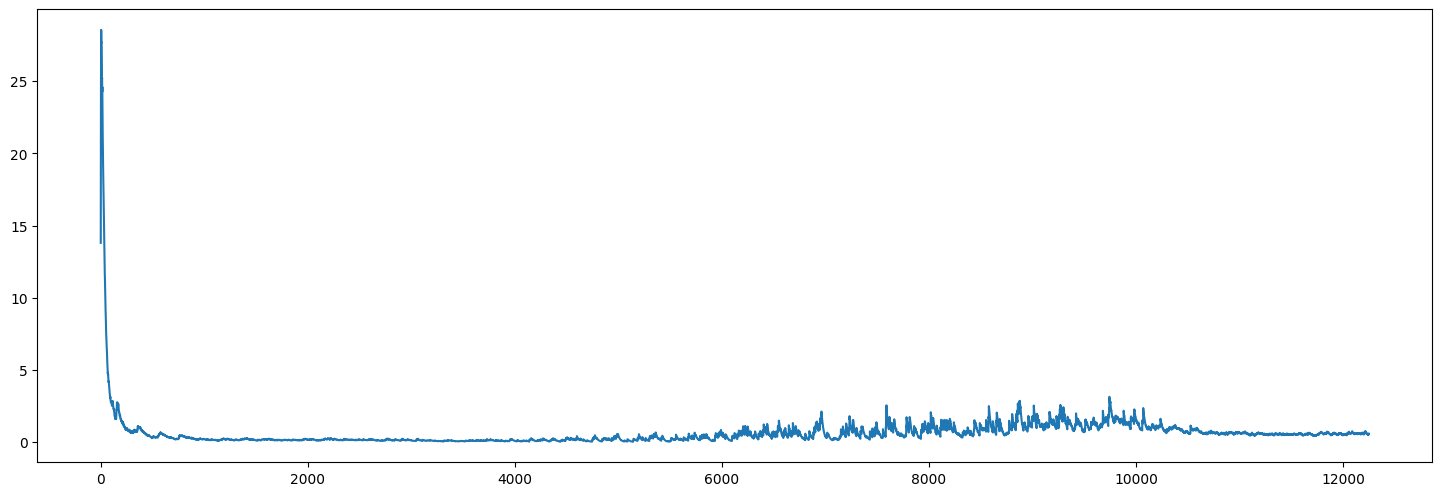

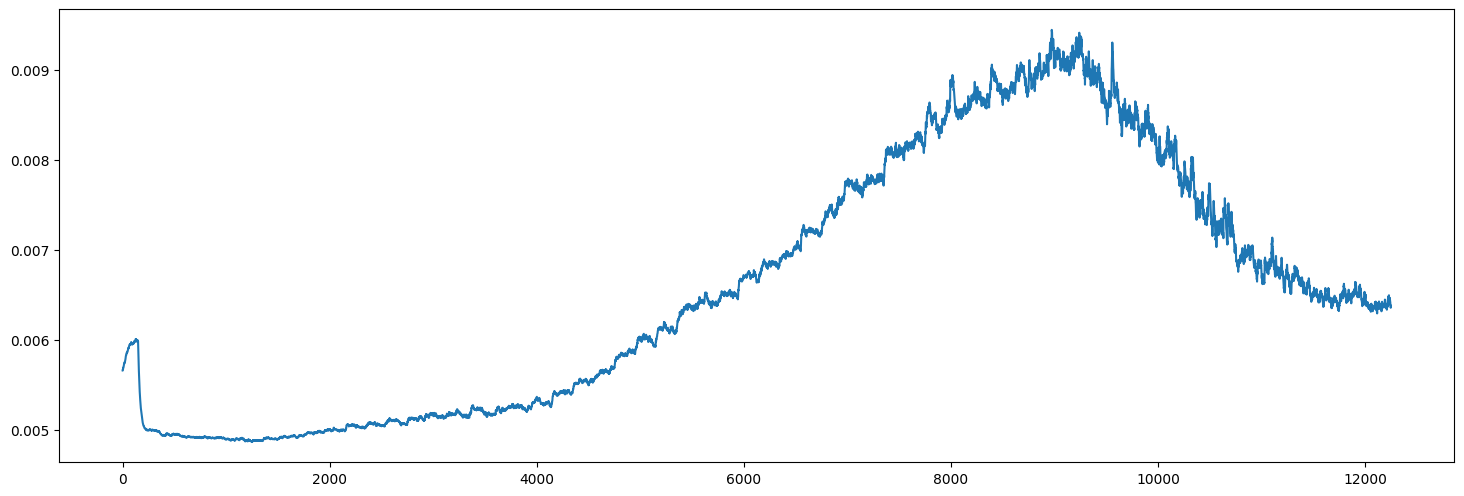

In [7]:
plt.figure(figsize=(18,6),dpi=100)
# plt.plot(smooth_curve(agent.loss_vec, factor=0.95))
plt.plot(smooth_curve(agent.loss_q_vec, factor=0.95))
plt.figure(figsize=(18,6),dpi=100)
plt.plot(smooth_curve(agent.loss_psi_vec, factor=0.95))
# plt.plot(agent.loss_vec)

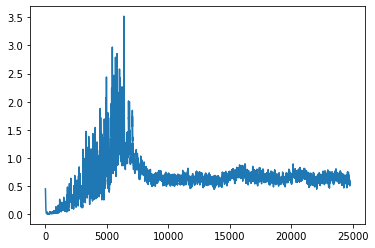

In [26]:
plt.plot(smooth_curve(agent.loss_vec, factor=0.95))
# plt.plot(agent.loss_vec)

In [ ]:
dqn_feature(game=game)

In [12]:
import re
%ls log/

CartPole-v0--run-0-200227-205236.txt  FourRooms--run-0-200302-131223.txt
CartPole-v0--run-0-200228-004756.txt  FourRooms--run-0-200302-133932.txt
CartPole-v0--run-0-200301-163526.txt  FourRooms--run-0-200302-142141.txt
CartPole-v0--run-0-200301-164329.txt  FourRooms--run-0-200302-142221.txt
CartPole-v0--run-0-200301-164446.txt  FourRooms--run-0-200302-142245.txt
CartPole-v0--run-0-200302-132052.txt  FourRooms--run-0-200302-142327.txt
FourRooms--run-0-200228-000646.txt    FourRooms--run-0-200302-142437.txt
FourRooms--run-0-200228-005249.txt    FourRooms--run-0-200302-142749.txt
FourRooms--run-0-200228-005912.txt    FourRooms--run-0-200302-143321.txt
FourRooms--run-0-200228-010316.txt    FourRooms--run-0-200302-143657.txt
FourRooms--run-0-200228-010531.txt    FourRooms--run-0-200302-155036.txt
FourRooms--run-0-200228-011410.txt    FourRooms--run-0-200302-155114.txt
FourRooms--run-0-200228-012330.txt    FourRooms--run-0-200302-155259.txt
FourRooms--run-0-200228-012412.txt    FourRooms--ru

In [13]:
def log2list(filename):
    returns_train = []
    returns_test = []
    with open(filename, 'rb') as f:
        while True:
            line = f.readline()
            split = re.split('\s', str(line))
            if not line:
                break
            if('episodic_return_train' in split):
                returns_train.append(float(split[-1][:-3]))
            if('episodic_return_test' in split):
                returns_test.append(float(split[-1][:-10]))
                
    return returns_train, returns_test

In [14]:
dsr_file = 'log/FourRooms--run-0-200308-160832.txt'
# dqn_file = 'log/FourRooms--run-0-200301-161113.txt'

In [15]:
train_dsr, test_dsr = log2list(dsr_file)
# train_dqn, test_dqn = log2list(dqn_file)
# train_max = min(len(train_dsr), len(train_dqn))
# test_max = min(len(test_dsr), len(test_dqn))

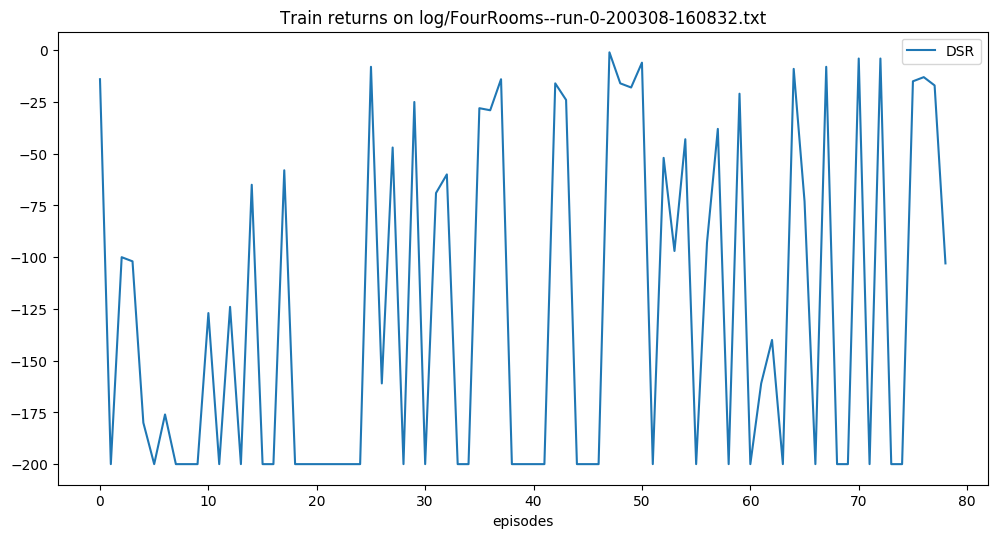

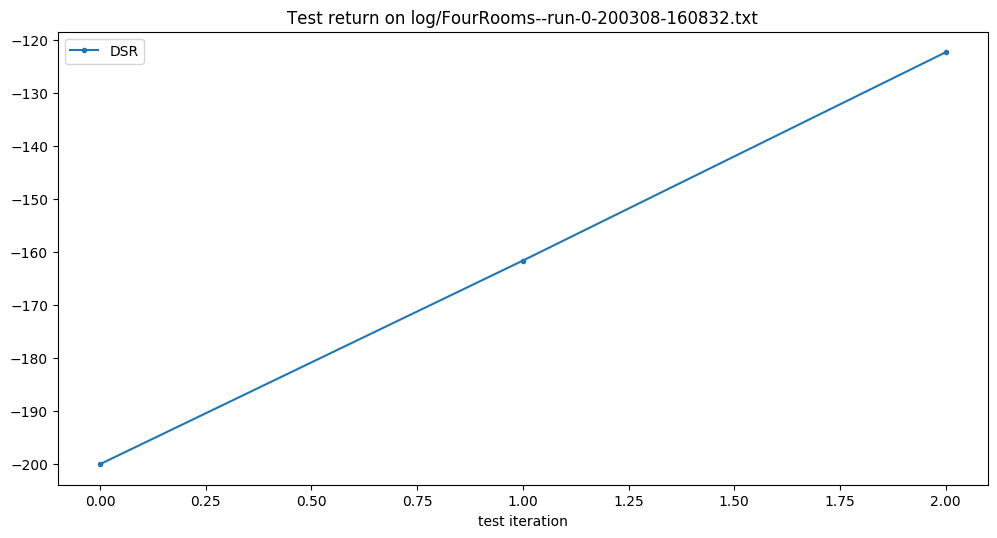

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), dpi=100)
# plt.plot(train_dqn[:train_max], label='DQN')
plt.plot(train_dsr[:], label='DSR')
plt.title('Train returns on ' + dsr_file)
plt.xlabel('episodes'), plt.legend()
plt.show()

plt.figure(figsize=(12,6), dpi=100)
# plt.plot(test_dqn[:test_max], '.-', label='DQN')
plt.plot(test_dsr[:], '.-', label='DSR')
plt.title('Test return on ' + dsr_file)
plt.xlabel('test iteration'), plt.legend()
plt.show()